First, create a new conda environment named BI2025 and install the required packages from requirements.txt


In [3]:
#!conda create -n BI2025 python=3.11 -y
#!conda activate BI2025
#!pip install -r requirements.txt

In [4]:
# DO NOT MODIFY OR COPY THIS CELL!! 
# Note: The only imports allowed are Python's standard library, pandas, numpy, scipy, matplotlib, seaborn and scikit-learn
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import plotly.express as px
import datetime
import typing
import requests
import time
import shutil
import json
from starvers.starvers import TripleStoreEngine
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
import copy
import uuid
from datetime import datetime

## Graph-based documentation preliminaries

**!!!IMPORTANT!!!**

Everytime you work on this notebook, enter your student ID in the `executed_by` variable so that the cell executions are accredited to you.

In [5]:
executed_by ='stud-id_12432813'  # Replace the digits after "id_" with your own student ID

Set your group and student IDs. Do this only once.

In [6]:
# group id for this project
group_id = '20'  # Replace the digits with your group id

# Students working on this notebook
student_a = 'stud-id_52400204'  # Replace the digits after "id_" with student A's student ID
student_b = 'stud-id_12432813'  # Replace the digits after "id_" with student B's student ID

In [7]:
# Roles. Don't change these values.
code_writer_role = 'code_writer'
code_executor_role = 'code_executor'

Setup the starvers API for logging your steps into our server-sided graph database.

In [8]:
get_endpoint = "https://starvers.ec.tuwien.ac.at/BI2025"
post_endpoint = "https://starvers.ec.tuwien.ac.at/BI2025/statements"
engine = TripleStoreEngine(get_endpoint, post_endpoint, skip_connection_test=True)

Use these prefixes in your notebooks. You can extend this dict with your prefixes of additional ontologies that you use in this notebook. Replace 00 with your group id

In [9]:
prefixes = {
    'xsd': 'http://www.w3.org/2001/XMLSchema#',
    'rdfs': 'http://www.w3.org/2000/01/rdf-schema#',
    'foaf': 'http://xmlns.com/foaf/0.1/',
    'prov': 'http://www.w3.org/ns/prov#',
    'sc': 'https://schema.org/',
    'cr': 'http://mlcommons.org/croissant/',
    'mls': 'http://www.w3.org/ns/mls#',
    'mlso': 'http://w3id.org/mlso',
    'siu': 'https://si-digital-framework.org/SI/units/',
    'siq': 'https://si-digital-framework.org/SI/quantities/',
    'qudt': 'http://qudt.org/schema/qudt/',
    '': f'https://starvers.ec.tuwien.ac.at/BI2025/{group_id}/',
}

prefix_header = '\n'.join([f'PREFIX {k}: <{v}>' for k, v in prefixes.items()]) + '\n\n'

In [10]:
print(prefix_header)

PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
PREFIX prov: <http://www.w3.org/ns/prov#>
PREFIX sc: <https://schema.org/>
PREFIX cr: <http://mlcommons.org/croissant/>
PREFIX mls: <http://www.w3.org/ns/mls#>
PREFIX mlso: <http://w3id.org/mlso>
PREFIX siu: <https://si-digital-framework.org/SI/units/>
PREFIX siq: <https://si-digital-framework.org/SI/quantities/>
PREFIX qudt: <http://qudt.org/schema/qudt/>
PREFIX : <https://starvers.ec.tuwien.ac.at/BI2025/20/>




Ontologies to use
* Provenance of the experiment process
    * PROV-O: 
        * doc: https://www.w3.org/TR/prov-o/
        * serialization: https://www.w3.org/ns/prov-o
* Data used and created
    * schema.org - Dataset: 
        * doc: https://schema.org/Dataset
        * serialization: https://schema.org/version/latest/schemaorg-current-https.ttl
    * Crossaint
        * doc: https://docs.mlcommons.org/croissant/docs/croissant-spec.html
        * serialization: https://github.com/mlcommons/croissant/blob/main/docs/croissant.ttl
* ML experiments performed
    * MLSO: 
        * doc: https://github.com/dtai-kg/MLSO
        * doc: https://dtai-kg.github.io/MLSO/#http://w3id.org/
        * serialization: https://dtai-kg.github.io/MLSO/ontology.ttl
* Measurements, Metrics, Units
    * QUDT
        * doc:https://qudt.org/
        * doc: https://github.com/qudt/qudt-public-repo
        * serialization: https://github.com/qudt/qudt-public-repo/blob/main/src/main/rdf/schema/SCHEMA_QUDT.ttl
    * SI Digital Framework
        * doc: https://github.com/TheBIPM/SI_Digital_Framework/blob/main/SI_Reference_Point/docs/README.md
        * doc: https://si-digital-framework.org/
        * doc: https://si-digital-framework.org/SI
        * serialization: https://github.com/TheBIPM/SI_Digital_Framework/blob/main/SI_Reference_Point/TTL/si.ttl
    * Quantities and Units
        * doc: https://www.omg.org/spec/Commons
        * serialization: https://www.omg.org/spec/Commons/QuantitiesAndUnits.ttl

Use this function to record execution times.

In [11]:
def now() -> str:
    """
    Returns the current time in ISO 8601 format with UTC timezone in the following format:
    YYYY-MM-DDTHH:MM:SS.sssZ
    """
    timestamp = datetime.datetime.now(datetime.timezone.utc)
    timestamp_formated = timestamp.strftime("%Y-%m-%dT%H:%M:%S.%f")[:-3]  +"Z"

    return timestamp_formated

Register yourself in the Knowledge Graph using ProvO. Change the given name, family name and immatriculation number to reflect your own data.

In [22]:
# Ontologies used: foaf, prov, IAO
reigstration_triples_a = [
f':{student_a} rdf:type foaf:Person .',
f':{student_a} rdf:type prov:Agent .',
f':{student_a} foaf:givenName "Muhammad Sajid" .',
f':{student_a} foaf:familyName "Bashir" .',
f':{student_a} <http://vivoweb.org/ontology/core#identifier> :{student_a} .',
f':{student_a} rdf:type <http://purl.obolibrary.org/obo/IAO_0000578> .',
f':{student_a} <http://www.w3.org/2000/01/rdf-schema#label> "Immatriculation number" .',
f':{student_a} <http://purl.obolibrary.org/obo/IAO_0000219> "52400204"^^xsd:string .',
]

reigstration_triples_b = [
f':{student_b} rdf:type foaf:Person .',
f':{student_b} rdf:type prov:Agent .',
f':{student_b} foaf:givenName "Eman" .',
f':{student_b} foaf:familyName "Shahin" .',
f':{student_b} <http://vivoweb.org/ontology/core#identifier> :{student_b} .',
f':{student_b} rdf:type <http://purl.obolibrary.org/obo/IAO_0000578> .',
f':{student_b} <http://www.w3.org/2000/01/rdf-schema#label> "Immatriculation number" .',
f':{student_b} <http://purl.obolibrary.org/obo/IAO_0000219> "12432813"^^xsd:string .',
]

role_triples = [
    f':{code_writer_role} rdf:type prov:Role .',
    f':{code_executor_role} rdf:type prov:Role .',
]


engine.insert(reigstration_triples_a, prefixes=prefixes)
engine.insert(reigstration_triples_b, prefixes=prefixes)
engine.insert(role_triples, prefixes=prefixes)

EndPointInternalError: EndPointInternalError: The endpoint returned the HTTP status code 500. 

Response:
b'java.lang.StackOverflowError'

**What not do do**

Do not use [blank nodes](https://www.w3.org/wiki/BlankNodes).

PROV-O uses blank nodes to connect multiple elements with each other.
Such blank nodes (such as _:association) should not be used.
Instead, assign a fixed node ID such as
:5119fcd7-b571-41e0-9464-a37c7be0f574 by generating them outside of the
notebook.
We suggest that, for each setting where such a blank node is needed to
connect multiple elements, you create a unique hash (using uuid.uuid4())
and keep this as hard-coded identifier for the blank node. The template
notebook contains examples of this. Do *not* use these provided values,
as otherwise, your provenance documentations will all be connected via
these identifiers!
Also, do not generate them dynamically in every cell execution, e.g. by
using uuid.uuid4() in a cell. This would generate many new linking nodes
for connecting the same elements.
Compute one for each node (cell) where you need them and make sure to
use the same one on each re-execution of the notebook.

In [13]:
#weather_data_path = os.path.join("data", "datasets", "weather")
#cyclists_data_path = os.path.join("data", "datasets", "cyclists")

# Paths to the dataset (Human Activity Recognition with Smartphones)
activity_data_path = os.path.join("data", "harws")

# Full paths to the train and test datasets
train_data_path = os.path.join(activity_data_path, "train.csv")
test_data_path = os.path.join(activity_data_path, "test.csv")


## Business Understanding 

#### Activity Recording Helper Functions

These utility functions standardize provenance documentation across all CRISP-DM sections, ensuring consistent structure, proper role attribution, and time tracking throughout the notebook.

In [15]:
# Provide a safe default if not defined earlier in the notebook
if 'UUID_NAMESPACE' not in globals():
    UUID_NAMESPACE = uuid.NAMESPACE_URL

# Existing globals expected: engine, prefixes, prefix_header, student_a, student_b, UUID_NAMESPACE,
# code_writer_role, code_executor_role, executed_by

# Helper function to escape special characters in RDF literals
def escape_rdf_literal(text: str) -> str:
    """Escape backslashes, quotes, newlines, and colons for SPARQL/RDF literals."""
    if not text:
        return ""
    # Escape in order: backslash first, then quotes, colons, and whitespace
    text = text.replace('\\', '\\\\')  # Escape backslashes first
    text = text.replace('"', '\\"')    # Escape quotes
    text = text.replace(':', '&#58;')  # Escape colons (use HTML entity)
    text = text.replace('\n', ' ')     # Replace newlines with spaces
    text = text.replace('\r', '')      # Remove carriage returns
    return text

def _det_uuid(name: str) -> str:
    return str(uuid.uuid5(UUID_NAMESPACE, name))

# Alias to match usage elsewhere in the notebook
# Keeps deterministic UUID behavior based on the shared UUID_NAMESPACE

def deterministic_uuid(name: str) -> str:
    return _det_uuid(name)


def record_activity(activity_id: str = None, activity_label: str = None, label: str = None,
                     code_writer: str = None, code_writers: list = None, code_executor: str = None,
                     start_time: str = None, end_time: str = None, 
                     description: str = None, comment: str = None,
                     parent_activity: str = None, phase_activity_iri: str = None,
                     inputs: list = None, outputs: list = None, deterministic: bool = False):
    """
    Records a generic PROV activity with flexible role handling.
    
    Parameters:
    - activity_id: unique activity identifier (used for deterministic UUID if deterministic=True)
    - activity_label or label: human-readable label
    - code_writer: single code writer id (converted to list internally)
    - code_writers: list of code writer ids (if code_writer not provided)
    - code_executor: executor id (defaults to global executed_by if None)
    - start_time, end_time: ISO datetime strings
    - description or comment: activity description
    - parent_activity or phase_activity_iri: parent activity IRI
    - inputs: list of input entity identifiers
    - outputs: list of output entity identifiers
    - deterministic: if True, return tuple (triples, executor_uuid, writer_uuid) for backward compatibility
    
    Returns: (activity_triples: list[str], activity_iri_or_executor_uuid, writer_uuid)
    """
    # Normalize parameters (support both old and new signatures)
    act_id = activity_id or label
    act_label = activity_label or label or act_id
    writers = [code_writer] if code_writer else (code_writers or [student_a])
    executor = code_executor or executed_by
    desc = description or comment
    parent = parent_activity or phase_activity_iri
    
    # Escape special characters in RDF literals
    act_label_escaped = escape_rdf_literal(act_label)
    desc_escaped = escape_rdf_literal(desc) if desc else None

    # Generate deterministic UUIDs for activity and associations
    activity_uuid = _det_uuid(f"act::{act_id}")
    activity_iri = f":{activity_uuid}"  # Use : prefix for activity IRI

    # Create activity triples
    triples = [
        f"{activity_iri} rdf:type prov:Activity .",
        f"{activity_iri} rdfs:label \"{act_label_escaped}\" ."
    ]

    if desc_escaped:
        triples.append(f"{activity_iri} rdfs:comment \"{desc_escaped}\" .")

    # Optional temporal bounds
    if start_time:
        triples.append(f"{activity_iri} prov:startedAtTime \"{start_time}\"^^xsd:dateTime .")
    if end_time:
        triples.append(f"{activity_iri} prov:endedAtTime \"{end_time}\"^^xsd:dateTime .")

    # Link to parent activity if provided
    if parent:
        triples.append(f"{activity_iri} prov:wasInformedBy {parent} .")

    # Qualified associations for code writers
    writer_uuids = []
    for idx, writer in enumerate(writers):
        writer_ass_uuid = _det_uuid(f"assoc::{act_id}::writer::{writer}::{idx}")
        writer_uuids.append(writer_ass_uuid)
        qn_writer = f":qual_assoc_writer_{writer_ass_uuid}"
        triples.extend([
            f"{activity_iri} prov:qualifiedAssociation {qn_writer} .",
            f"{qn_writer} rdf:type prov:Association .",
            f"{qn_writer} rdfs:label \"code writer\" .",
            f"{qn_writer} prov:hadRole {code_writer_role} .",
            f"{qn_writer} prov:agent :{writer} .",
        ])

    # Qualified association for executor
    exec_uuid = _det_uuid(f"assoc::{act_id}::executor::{executor}")
    qn_exec = f":qual_assoc_executor_{exec_uuid}"
    triples.extend([
        f"{activity_iri} prov:qualifiedAssociation {qn_exec} .",
        f"{qn_exec} rdf:type prov:Association .",
        f"{qn_exec} rdfs:label \"code executor\" .",
        f"{qn_exec} prov:hadRole {code_executor_role} .",
        f"{qn_exec} prov:agent :{executor} .",
    ])

    # Add input entities
    if inputs:
        for inp in inputs:
            inp_iri = f":{inp}"
            triples.append(f"{activity_iri} prov:used {inp_iri} .")

    # Add output entities
    if outputs:
        for out in outputs:
            out_iri = f":{out}"
            triples.append(f"{activity_iri} prov:wasGeneratedBy {out_iri} .")

    # Return format: support both old (activity_triples, activity_iri) and new (activity_triples, executor_uuid, writer_uuid)
    if deterministic:
        # Return tuple compatible with: triples, executor_uuid, writer_uuid = record_activity(...)
        return triples, exec_uuid, (writer_uuids[0] if writer_uuids else None)
    else:
        return triples, activity_iri


def record_entity(activity_id: str = None, label: str = None, comment: str = None):
    """Record a PROV entity."""
    entity_id = activity_id or label
    entity_uuid = _det_uuid(f"ent::{entity_id}")
    entity_iri = f":{entity_uuid}"
    comment_escaped = escape_rdf_literal(comment) if comment else None
    triples = [
        f"{entity_iri} rdf:type prov:Entity .",
        f"{entity_iri} rdfs:label \"{label or entity_id}\" ."
    ]
    if comment_escaped:
        triples.append(f"{entity_iri} rdfs:comment \"{comment_escaped}\" .")
    return triples, entity_iri


def record_interpretation(activity_id: str = None, activity_label: str = None, 
                         code_executor: str = None,
                         interpretation_text: str = None, text: str = None,
                         inputs: list = None, output_entity: str = None,
                         parent_activity: str = None, deterministic: bool = False):
    """Record an interpretation (specialized entity generated by an activity)."""
    interp_id = activity_id or activity_label
    interp_text = interpretation_text or text or ""
    # Escape special characters in RDF literals
    interp_text_escaped = escape_rdf_literal(interp_text)
    executor = code_executor or executed_by
    
    # Create interpretation activity
    interp_uuid = _det_uuid(f"interp::{interp_id}")
    interp_iri = f":{interp_uuid}"
    
    triples = [
        f"{interp_iri} rdf:type prov:Activity .",
        f"{interp_iri} rdfs:label \"{escape_rdf_literal(activity_label or interp_id)}\" .",
        f"{interp_iri} rdfs:comment \"{interp_text_escaped}\" ."
    ]
    
    if parent_activity:
        triples.append(f"{interp_iri} prov:wasInformedBy {parent_activity} .")
    
    # Executor association
    exec_ass_uuid = _det_uuid(f"assoc::{interp_id}::executor::{executor}")
    qn_exec = f":qual_exec_{exec_ass_uuid}"
    triples.extend([
        f"{interp_iri} prov:qualifiedAssociation {qn_exec} .",
        f"{qn_exec} rdf:type prov:Association .",
        f"{qn_exec} prov:hadRole {code_executor_role} .",
        f"{qn_exec} prov:agent :{executor} .",
    ])
    
    # Input entities
    if inputs:
        for inp in inputs:
            inp_iri = f":{inp}"
            triples.append(f"{interp_iri} prov:used {inp_iri} .")
    
    # Output entity (the interpretation result)
    if output_entity:
        out_iri = f":{output_entity}"
        triples.append(f"{interp_iri} prov:generated {out_iri} .")
    
    if deterministic:
        return triples, interp_uuid
    return triples, interp_iri


def record_decision(activity_id: str = None, activity_label: str = None, 
                   code_executor: str = None,
                   text: str = None, comment: str = None,
                   inputs: list = None, output_entity: str = None,
                   parent_activity: str = None, deterministic: bool = False):
    """Record a decision (specialized interpretation/entity)."""
    dec_id = activity_id or activity_label
    dec_text = text or comment or ""
    # Escape special characters in RDF literals
    dec_text_escaped = escape_rdf_literal(dec_text)
    executor = code_executor or executed_by
    
    dec_uuid = _det_uuid(f"decision::{dec_id}")
    dec_iri = f":{dec_uuid}"
    
    triples = [
        f"{dec_iri} rdf:type prov:Activity .",
        f"{dec_iri} rdfs:label \"{escape_rdf_literal(activity_label or dec_id)}\" .",
        f"{dec_iri} rdfs:comment \"{dec_text_escaped}\" ."
    ]
    
    if parent_activity:
        triples.append(f"{dec_iri} prov:wasInformedBy {parent_activity} .")
    
    # Executor association
    exec_ass_uuid = _det_uuid(f"assoc::{dec_id}::executor::{executor}")
    qn_exec = f":qual_exec_{exec_ass_uuid}"
    triples.extend([
        f"{dec_iri} prov:qualifiedAssociation {qn_exec} .",
        f"{qn_exec} rdf:type prov:Association .",
        f"{qn_exec} prov:hadRole {code_executor_role} .",
        f"{qn_exec} prov:agent :{executor} .",
    ])
    
    if inputs:
        for inp in inputs:
            inp_iri = f":{inp}"
            triples.append(f"{dec_iri} prov:used {inp_iri} .")
    
    if output_entity:
        out_iri = f":{output_entity}"
        triples.append(f"{dec_iri} prov:generated {out_iri} .")
    
    if deterministic:
        return triples, dec_uuid
    return triples, dec_iri


def now() -> str:
    """Return current UTC time in ISO 8601 format with Z suffix."""
    return datetime.utcnow().replace(microsecond=0).isoformat() + "Z"


def now_iso() -> str:
    """Alias for now()."""
    return now()


print("Helper functions loaded: record_activity, record_entity, record_interpretation, record_decision, now, now_iso")

print("Helper functions loaded: flexible role handling + deterministic_uuid + proper RDF escaping.")

Helper functions loaded: record_activity, record_entity, record_interpretation, record_decision, now, now_iso
Helper functions loaded: flexible role handling + deterministic_uuid + proper RDF escaping.


In [17]:
# Data Understanding phase setup: writers, executor, and phase activity
data_understanding_code_writer = student_a  # Sajid (A)
data_understanding_code_writer_b = student_b  # Shahin (B, assisting)
data_understanding_executor = executed_by  # current executor
du_phase_uuid_writer_a = deterministic_uuid("data_understanding_phase:writer:student_a")
du_phase_uuid_writer_b = deterministic_uuid("data_understanding_phase:writer:student_b")
du_phase_uuid_executor = deterministic_uuid("data_understanding_phase:executor")

data_understanding_phase_activity = [
    f':data_understanding_phase rdf:type prov:Activity .',
    f':data_understanding_phase rdfs:label "Data Understanding Phase" .',
    # Writer A
    f':data_understanding_phase prov:qualifiedAssociation :{du_phase_uuid_writer_a} .',
    f':{du_phase_uuid_writer_a} prov:agent :{data_understanding_code_writer} .',
    f':{du_phase_uuid_writer_a} rdf:type prov:Association .',
    f':{du_phase_uuid_writer_a} prov:hadRole :{code_writer_role} .',
    # Writer B
    f':data_understanding_phase prov:qualifiedAssociation :{du_phase_uuid_writer_b} .',
    f':{du_phase_uuid_writer_b} prov:agent :{data_understanding_code_writer_b} .',
    f':{du_phase_uuid_writer_b} rdf:type prov:Association .',
    f':{du_phase_uuid_writer_b} prov:hadRole :{code_writer_role} .',
    # Executor
    f':data_understanding_phase prov:qualifiedAssociation :{du_phase_uuid_executor} .',
    f':{du_phase_uuid_executor} prov:agent :{data_understanding_executor} .',
    f':{du_phase_uuid_executor} rdf:type prov:Association .',
    f':{du_phase_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(data_understanding_phase_activity, prefixes=prefixes)

print("Data Understanding phase initialized with writers A & B and executor.")

EndPointInternalError: EndPointInternalError: The endpoint returned the HTTP status code 500. 

Response:
b'java.lang.StackOverflowError'

In [18]:
## Each Activity that follows is part of the Business Understanding Phase

business_understanding_phase_executor = [
f':business_understanding_phase rdf:type prov:Activity .',
f':business_understanding_phase rdfs:label "Business Understanding Phase" .', ## Phase 1: Business Understanding
]
engine.insert(business_understanding_phase_executor, prefixes=prefixes)


EndPointInternalError: EndPointInternalError: The endpoint returned the HTTP status code 500. 

Response:
b'java.lang.StackOverflowError'

In [19]:
#############################################
# Documentation
#############################################

data_src_and_scenario_comment = """
The dataset used in this project is the Human Activity Recognition with Smartphones dataset, 
published by UCI and available on Kaggle. It contains sensor measurements collected from 
30 volunteers wearing a Samsung Galaxy S II smartphone on their waist while performing 
six everyday activities: walking, walking upstairs, walking downstairs, sitting, standing, 
and laying. The phone recorded accelerometer and gyroscope readings at 50 Hz, and the 
researchers transformed these raw signals into 561 numerical features.

Scenario:
A realistic scenario for this dataset is the development of applications that can automatically 
recognize what a user is doing based only on their smartphone sensors. This could be useful in 
many areas — for example, health monitoring, fitness apps, or detecting inactivity in elderly care. 
There are also commercial and marketing-related possibilities, such as tailoring notifications or 
recommendations based on what the user is currently doing, or understanding long-term activity 
patterns to improve customer segmentation. This dataset allows us to evaluate how well machine learning models can classify physical activities in these contexts.
"""

business_objectives_comment = """
The main goal of this project is to build a model that can reliably identify a person's activity 
based on smartphone sensor data. This kind of model can support different applications, such as 
health and wellness apps, fall-detection systems, or activity tracking tools.

Beyond health-related uses, such a model can also support commercial goals. Companies might use 
activity recognition to send notifications or recommendations at the right moment, or to better 
understand user behavior for marketing and personalization. For example, an app might promote a 
fitness offer when the user is active, or delay non-urgent notifications until the user is not moving.

Overall, the objective is to evaluate how well a data-driven model can classify activities and how 
such a system might offer practical value in both personal and commercial applications.
"""

business_success_criteria_comment = """
For this project to be considered successful from a business perspective, the activity recognition 
model should perform well enough to be useful in real applications. As a general guideline, an 
accuracy around 85% or higher would be a good sign that the model is reliable.

It is also important that the model performs reasonably across all activities and not only on the 
most common ones. In addition, the system should be fast enough for real-time use on a smartphone.

Success also depends on whether the predictions are useful for the intended application — whether 
that iss improving user engagement, supporting health monitoring, or enabling more personalized 
recommendations. If the results support these types of decisions in a meaningful way, we can 
consider the project successful.
"""

data_mining_goals_comment = """
The main data mining goal is to build and evaluate a machine learning model that predicts one of 
six activity labels using the smartphone sensor features. This involves testing different algorithms 
and comparing their strengths and weaknesses.

Another goal is to understand which features contribute most to distinguishing the activities and 
to check how stable the model is across different subjects. Since the dataset has many engineered 
features, part of the goal is also to explore the data structure and understand how the signals 
translate into recognizable activity patterns.

In addition to building a classifier, the goal is to see whether the resulting model is good enough 
to support real-world scenarios, such as personalized services, smarter notification timing, or 
insights for customer profiling.
"""

data_mining_success_criteria_comment = """
We consider the data mining process successful if the model achieves solid performance across 
the usual evaluation metrics, such as accuracy, precision, recall, and F1-score. Ideally, the 
model should reach at least around 85% accuracy on the test data and show balanced performance 
across all classes.

The process should also be reproducible. This means documenting how the data was prepared, 
how the train/validation/test splits were done, and which parameters were used for training.

Finally, success also depends on whether the model is stable and behaves consistently during 
cross-validation. The results should be understandable enough to support the practical or business-related 
applications described earlier
"""

ai_risk_aspects_comment = """
There are a few risks to consider when working with an activity recognition system. The dataset 
comes from only 30 young adults, so the model might not generalize well to older people, children, 
or individuals with movement limitations. This could introduce bias.

Although the dataset does not include identifiable personal information, long-term activity patterns 
could still reveal sensitive details about a person’s routine or health. In commercial settings, this 
raises questions about consent, privacy, and how such information might be used.

There is also the risk of misclassifying activities. In health-related applications, this could lead to 
missed warnings or incorrect assumptions about a user’s condition. Even in marketing contexts, 
poor predictions could result in irrelevant or poorly timed notifications.

Finally, the study used a specific smartphone model placed at a fixed location on the waist. Real-world 
usage is more varied, and differences in device placement or sensor quality could affect performance.
"""

# Deterministic UUIDs for associations
bu_code_writer_uuid = deterministic_uuid("business_understanding:writer:student_a")
bu_code_writer_uuid_b = deterministic_uuid("business_understanding:writer:student_b")
bu_code_executor_uuid = deterministic_uuid("business_understanding:executor")

# Set identities for writer(s) and executor
business_understanding_code_writer = student_a  # Student A (Sajid)
business_understanding_code_writer_b = student_b  # Student B (Eman)
bu_code_executor = executed_by  # whoever is executing now

# Ensure the parent phase activity exists (minimal definition)
business_understanding_phase_activity = [
    f':business_understanding_phase rdf:type prov:Activity .',
    f':business_understanding_phase rdfs:label "Business Understanding Phase" .',
]
engine.insert(business_understanding_phase_activity, prefixes=prefixes)

# Record the Business Understanding activity with both writers and the executor
business_understanding_activity = [
    f':business_understanding rdf:type prov:Activity .',
    f':business_understanding rdfs:label "1. Business Understanding" .',
    f':business_understanding sc:isPartOf :business_understanding_phase .',
    # Code Writer A
    f':business_understanding prov:qualifiedAssociation :{bu_code_writer_uuid} .',
    f':{bu_code_writer_uuid} prov:agent :{business_understanding_code_writer} .',
    f':{bu_code_writer_uuid} rdf:type prov:Association .',
    f':{bu_code_writer_uuid} prov:hadRole :{code_writer_role} .',
    # Code Writer B
    f':business_understanding prov:qualifiedAssociation :{bu_code_writer_uuid_b} .',
    f':{bu_code_writer_uuid_b} prov:agent :{business_understanding_code_writer_b} .',
    f':{bu_code_writer_uuid_b} rdf:type prov:Association .',
    f':{bu_code_writer_uuid_b} prov:hadRole :{code_writer_role} .',
    # Code Executor
    f':business_understanding prov:qualifiedAssociation :{bu_code_executor_uuid} .',
    f':{bu_code_executor_uuid} prov:agent :{bu_code_executor} .',
    f':{bu_code_executor_uuid} rdf:type prov:Association .',
    f':{bu_code_executor_uuid} prov:hadRole :{code_executor_role} .',
]
engine.insert(business_understanding_activity, prefixes=prefixes)

# Entities for 1a–1f
business_understanding_data_executor = [
    # 1a
    f':bu_data_source_and_scenario rdf:type prov:Entity .',
    f':bu_data_source_and_scenario prov:wasGeneratedBy :business_understanding .',
    f':bu_data_source_and_scenario rdfs:label "1a Data Source and Scenario" .',
    f':bu_data_source_and_scenario rdfs:comment """{data_src_and_scenario_comment}""" .',
    # 1b
    f':bu_business_objectives rdf:type prov:Entity .',
    f':bu_business_objectives prov:wasGeneratedBy :business_understanding .',
    f':bu_business_objectives rdfs:label "1b Business Objectives" .',
    f':bu_business_objectives rdfs:comment """{business_objectives_comment}""" .',
    # 1c
    f':bu_business_success_criteria rdf:type prov:Entity .',
    f':bu_business_success_criteria prov:wasGeneratedBy :business_understanding .',
    f':bu_business_success_criteria rdfs:label "1c Business Success Criteria" .',
    f':bu_business_success_criteria rdfs:comment """{business_success_criteria_comment}""" .',
    # 1d
    f':bu_data_mining_goals rdf:type prov:Entity .',
    f':bu_data_mining_goals prov:wasGeneratedBy :business_understanding .',
    f':bu_data_mining_goals rdfs:label "1d Data Mining Goals" .',
    f':bu_data_mining_goals rdfs:comment """{data_mining_goals_comment}""" .',
    # 1e
    f':bu_data_mining_success_criteria rdf:type prov:Entity .',
    f':bu_data_mining_success_criteria prov:wasGeneratedBy :business_understanding .',
    f':bu_data_mining_success_criteria rdfs:label "1e Data Mining Success Criteria" .',
    f':bu_data_mining_success_criteria rdfs:comment """{data_mining_success_criteria_comment}""" .',
    # 1f
    f':bu_ai_risk_aspects rdf:type prov:Entity .',
    f':bu_ai_risk_aspects prov:wasGeneratedBy :business_understanding .',
    f':bu_ai_risk_aspects rdfs:label "1f AI risk aspects" .',
    f':bu_ai_risk_aspects rdfs:comment """{ai_risk_aspects_comment}""" .',
]
engine.insert(business_understanding_data_executor, prefixes=prefixes)


EndPointInternalError: EndPointInternalError: The endpoint returned the HTTP status code 500. 

Response:
b'java.lang.StackOverflowError'

## Data Understanding

The following pseudo-code & pseudo-documentation may be used as a hint.

In [20]:
## Each Activity that follows is part of the Data Understanding Phase

data_understanding_phase_executor  = [
f':data_understanding_phase rdf:type prov:Activity .',
f':data_understanding_phase rdfs:label "Data Understanding Phase" .', 
]
engine.insert(data_understanding_phase_executor, prefixes=prefixes)


EndPointInternalError: EndPointInternalError: The endpoint returned the HTTP status code 500. 

Response:
b'java.lang.StackOverflowError'

In [21]:
load_har_data_code_writer = student_a

def load_har_data() -> typing.Tuple[pd.DataFrame, pd.DataFrame]:
    train_df = pd.read_csv(train_data_path)
    test_df = pd.read_csv(test_data_path)
    return train_df, test_df

start_time_ld = now()
train_df, test_df = load_har_data()
end_time_ld = now()

display(train_df.head())


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,STANDING


In [23]:
# Provenance: Data loading activity
load_har_data_code_writer = student_a

ld_report = """
Loaded the Human Activity Recognition (HAR) training and test sets.
The dataset contains sensor readings from 30 subjects performing 6 activities.
"""

# Generate deterministic UUIDs for associations (following the reference template)
du_load_ass_uuid_executor = deterministic_uuid("load_har_data:executor:activity")
du_load_ass_uuid_writer = deterministic_uuid("load_har_data:writer:activity")

# Build activity triples following the reference template structure
load_activity_triples = [
    ':load_har_data rdf:type prov:Activity .',
    ':load_har_data sc:isPartOf :data_understanding_phase .',
    ':load_har_data rdfs:comment "Load HAR Dataset" .',
    f':load_har_data rdfs:comment """{ld_report}""" .',
    f':load_har_data prov:startedAtTime "{start_time_ld}"^^xsd:dateTime .',
    f':load_har_data prov:endedAtTime "{end_time_ld}"^^xsd:dateTime .',
    # Writer association
    f':load_har_data prov:qualifiedAssociation :{du_load_ass_uuid_writer} .',
    f':{du_load_ass_uuid_writer} prov:agent :{load_har_data_code_writer} .',
    f':{du_load_ass_uuid_writer} rdf:type prov:Association .',
    f':{du_load_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    # Executor association
    f':load_har_data prov:qualifiedAssociation :{du_load_ass_uuid_executor} .',
    f':{du_load_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{du_load_ass_uuid_executor} rdf:type prov:Association .',
    f':{du_load_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
    # Input entities
    ':load_har_data prov:used :har_train_file .',
    ':load_har_data prov:used :har_test_file .',
    ':har_train_file rdf:type prov:Entity .',
    ':har_test_file rdf:type prov:Entity .',
    # Output entities
    ':train_df rdf:type prov:Entity .',
    ':train_df prov:wasGeneratedBy :load_har_data .',
    ':test_df rdf:type prov:Entity .',
    ':test_df prov:wasGeneratedBy :load_har_data .',
]

engine.insert(load_activity_triples, prefixes=prefixes)

# Document the HAR training dataset structure using Croissant schema
har_dataset_triples = [
    # Dataset description
    ':train_df rdf:type sc:Dataset .',
    ':train_df sc:name "HAR Training Dataset" .',
    ':train_df sc:description "Training set of the Human Activity Recognition dataset using smartphone accelerometer and gyroscope measurements." .',

    # Explanation of field coverage
    ':train_df rdfs:comment """The HAR dataset contains 561 engineered features derived from smartphone accelerometer and gyroscope signals. To keep the provenance graph concise, detailed field semantics are documented in Section 2a where a representative subset is modeled.""" .',

    # RecordSet definition
    ':har_recordset rdf:type cr:RecordSet .',
    ':har_recordset sc:name "HAR Feature RecordSet" .',
    ':train_df cr:recordSet :har_recordset .',
]

engine.insert(har_dataset_triples, prefixes=prefixes)

# Document the HAR test dataset
har_test_dataset_triples = [
    ':test_df rdf:type sc:Dataset .',
    ':test_df sc:name "HAR Test Dataset" .',
    ':test_df sc:description "Test portion of the Human Activity Recognition dataset, used only for final evaluation." .',
    ':test_df rdfs:comment """The HAR test dataset contains the same 561 engineered features as the training dataset. Attribute semantics are documented once on the training split in Section 2a to avoid duplication.""" .',
]

engine.insert(har_test_dataset_triples, prefixes=prefixes)

EndPointInternalError: EndPointInternalError: The endpoint returned the HTTP status code 500. 

Response:
b'java.lang.StackOverflowError'

### 2a) Attribute Types, Units of Measurement, and Semantics

In [24]:
# 2a) Attribute Types, Units of Measurement, and Semantics
# Document all attributes with their types, units, and semantic meaning

data_understanding_code_writer = student_a
du_2a_code_writer = student_a

# Generate deterministic UUIDs for 2a activity
du_2a_ass_uuid_executor = deterministic_uuid("du_2a_attribute_types:executor:activity")
du_2a_ass_uuid_writer = deterministic_uuid("du_2a_attribute_types:writer:activity")

# Start time for 2a activity
start_time_2a = now()

# Document the attribute types and semantics activity
du_2a_activity_triples = [
    ':du_2a_attribute_types rdf:type prov:Activity .',
    ':du_2a_attribute_types sc:isPartOf :data_understanding_phase .',
    ':du_2a_attribute_types rdfs:label "2a) Attribute Types, Units, and Semantics" .',
    ':du_2a_attribute_types rdfs:comment "Document all HAR dataset attributes with their data types, units of measurement, and semantic descriptions." .',
    f':du_2a_attribute_types prov:startedAtTime "{start_time_2a}"^^xsd:dateTime .',
    # Writer association
    f':du_2a_attribute_types prov:qualifiedAssociation :{du_2a_ass_uuid_writer} .',
    f':{du_2a_ass_uuid_writer} prov:agent :{du_2a_code_writer} .',
    f':{du_2a_ass_uuid_writer} rdf:type prov:Association .',
    f':{du_2a_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    # Executor association
    f':du_2a_attribute_types prov:qualifiedAssociation :{du_2a_ass_uuid_executor} .',
    f':{du_2a_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{du_2a_ass_uuid_executor} rdf:type prov:Association .',
    f':{du_2a_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
    # Input: the loaded dataset
    ':du_2a_attribute_types prov:used :train_df .',
]

engine.insert(du_2a_activity_triples, prefixes=prefixes)

# Define attributes for the HAR training dataset using Croissant schema
# HAR dataset has accelerometer and gyroscope features from smartphones
har_2a_fields_triples = [
    # Subject label field
    ':subject_field rdf:type cr:Field .',
    ':subject_field sc:name "Subject" .',
    ':subject_field sc:description "Identifier of the subject (1-30) who performed the activity. Smartphone worn on waist." .',
    ':subject_field cr:dataType xsd:integer .',
    ':subject_field qudt:unit qudt:Dimensionless .',
    ':har_recordset cr:field :subject_field .',

    # Activity label field
    ':activity_field rdf:type cr:Field .',
    ':activity_field sc:name "Activity" .',
    ':activity_field sc:description "Type of activity performed: WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, STANDING, LAYING" .',
    ':activity_field cr:dataType xsd:string .',
    ':har_recordset cr:field :activity_field .',

    # Time-Domain Features (Accelerometer)
    # Sample mean of acceleration signal (X, Y, Z axes)
    ':tBodyAcc_mean_X_field_2a rdf:type cr:Field .',
    ':tBodyAcc_mean_X_field_2a sc:name "tBodyAcc-mean()-X" .',
    ':tBodyAcc_mean_X_field_2a sc:description "Mean of the body acceleration signal (time domain) along X-axis (normalized: -1 to 1)." .',
    ':tBodyAcc_mean_X_field_2a cr:dataType xsd:double .',
    ':tBodyAcc_mean_X_field_2a qudt:unit qudt:StandardAccelerationOfGravity .',
    ':har_recordset cr:field :tBodyAcc_mean_X_field_2a .',

    ':tBodyAcc_mean_Y_field_2a rdf:type cr:Field .',
    ':tBodyAcc_mean_Y_field_2a sc:name "tBodyAcc-mean()-Y" .',
    ':tBodyAcc_mean_Y_field_2a sc:description "Mean of the body acceleration signal (time domain) along Y-axis (normalized: -1 to 1)." .',
    ':tBodyAcc_mean_Y_field_2a cr:dataType xsd:double .',
    ':tBodyAcc_mean_Y_field_2a qudt:unit qudt:StandardAccelerationOfGravity .',
    ':har_recordset cr:field :tBodyAcc_mean_Y_field_2a .',

    ':tBodyAcc_mean_Z_field_2a rdf:type cr:Field .',
    ':tBodyAcc_mean_Z_field_2a sc:name "tBodyAcc-mean()-Z" .',
    ':tBodyAcc_mean_Z_field_2a sc:description "Mean of the body acceleration signal (time domain) along Z-axis (normalized: -1 to 1)." .',
    ':tBodyAcc_mean_Z_field_2a cr:dataType xsd:double .',
    ':tBodyAcc_mean_Z_field_2a qudt:unit qudt:StandardAccelerationOfGravity .',
    ':har_recordset cr:field :tBodyAcc_mean_Z_field_2a .',

    # Standard deviation of acceleration
    ':tBodyAcc_std_X_field_2a rdf:type cr:Field .',
    ':tBodyAcc_std_X_field_2a sc:name "tBodyAcc-std()-X" .',
    ':tBodyAcc_std_X_field_2a sc:description "Standard deviation of body acceleration signal (time domain) along X-axis (normalized: -1 to 1)." .',
    ':tBodyAcc_std_X_field_2a cr:dataType xsd:double .',
    ':tBodyAcc_std_X_field_2a qudt:unit qudt:StandardAccelerationOfGravity .',
    ':har_recordset cr:field :tBodyAcc_std_X_field_2a .',

    ':tBodyAcc_std_Y_field_2a rdf:type cr:Field .',
    ':tBodyAcc_std_Y_field_2a sc:name "tBodyAcc-std()-Y" .',
    ':tBodyAcc_std_Y_field_2a sc:description "Standard deviation of body acceleration signal (time domain) along Y-axis (normalized: -1 to 1)." .',
    ':tBodyAcc_std_Y_field_2a cr:dataType xsd:double .',
    ':tBodyAcc_std_Y_field_2a qudt:unit qudt:StandardAccelerationOfGravity .',
    ':har_recordset cr:field :tBodyAcc_std_Y_field_2a .',

    ':tBodyAcc_std_Z_field_2a rdf:type cr:Field .',
    ':tBodyAcc_std_Z_field_2a sc:name "tBodyAcc-std()-Z" .',
    ':tBodyAcc_std_Z_field_2a sc:description "Standard deviation of body acceleration signal (time domain) along Z-axis (normalized: -1 to 1)." .',
    ':tBodyAcc_std_Z_field_2a cr:dataType xsd:double .',
    ':tBodyAcc_std_Z_field_2a qudt:unit qudt:StandardAccelerationOfGravity .',
    ':har_recordset cr:field :tBodyAcc_std_Z_field_2a .',

    # Gyroscope Features (Angular velocity)
    ':tBodyGyro_mean_X_field_2a rdf:type cr:Field .',
    ':tBodyGyro_mean_X_field_2a sc:name "tBodyGyro-mean()-X" .',
    ':tBodyGyro_mean_X_field_2a sc:description "Mean angular velocity of body (time domain) around X-axis (normalized: -1 to 1). Units: radians/second." .',
    ':tBodyGyro_mean_X_field_2a cr:dataType xsd:double .',
    ':tBodyGyro_mean_X_field_2a qudt:unit siu:radian_per_second .',
    ':har_recordset cr:field :tBodyGyro_mean_X_field_2a .',

    ':tBodyGyro_mean_Y_field_2a rdf:type cr:Field .',
    ':tBodyGyro_mean_Y_field_2a sc:name "tBodyGyro-mean()-Y" .',
    ':tBodyGyro_mean_Y_field_2a sc:description "Mean angular velocity of body (time domain) around Y-axis (normalized: -1 to 1). Units: radians/second." .',
    ':tBodyGyro_mean_Y_field_2a cr:dataType xsd:double .',
    ':tBodyGyro_mean_Y_field_2a qudt:unit siu:radian_per_second .',
    ':har_recordset cr:field :tBodyGyro_mean_Y_field_2a .',

    ':tBodyGyro_mean_Z_field_2a rdf:type cr:Field .',
    ':tBodyGyro_mean_Z_field_2a sc:name "tBodyGyro-mean()-Z" .',
    ':tBodyGyro_mean_Z_field_2a sc:description "Mean angular velocity of body (time domain) around Z-axis (normalized: -1 to 1). Units: radians/second." .',
    ':tBodyGyro_mean_Z_field_2a cr:dataType xsd:double .',
    ':tBodyGyro_mean_Z_field_2a qudt:unit siu:radian_per_second .',
    ':har_recordset cr:field :tBodyGyro_mean_Z_field_2a .',

    # Frequency-Domain Features (FFT of signals)
    ':fBodyAcc_mean_X_field_2a rdf:type cr:Field .',
    ':fBodyAcc_mean_X_field_2a sc:name "fBodyAcc-mean()-X" .',
    ':fBodyAcc_mean_X_field_2a sc:description "Mean frequency-domain body acceleration along X-axis (normalized: -1 to 1). Computed via FFT." .',
    ':fBodyAcc_mean_X_field_2a cr:dataType xsd:double .',
    ':fBodyAcc_mean_X_field_2a qudt:unit qudt:StandardAccelerationOfGravity .',
    ':har_recordset cr:field :fBodyAcc_mean_X_field_2a .',

    ':fBodyAcc_mean_Y_field_2a rdf:type cr:Field .',
    ':fBodyAcc_mean_Y_field_2a sc:name "fBodyAcc-mean()-Y" .',
    ':fBodyAcc_mean_Y_field_2a sc:description "Mean frequency-domain body acceleration along Y-axis (normalized: -1 to 1). Computed via FFT." .',
    ':fBodyAcc_mean_Y_field_2a cr:dataType xsd:double .',
    ':fBodyAcc_mean_Y_field_2a qudt:unit qudt:StandardAccelerationOfGravity .',
    ':har_recordset cr:field :fBodyAcc_mean_Y_field_2a .',

    ':fBodyAcc_mean_Z_field_2a rdf:type cr:Field .',
    ':fBodyAcc_mean_Z_field_2a sc:name "fBodyAcc-mean()-Z" .',
    ':fBodyAcc_mean_Z_field_2a sc:description "Mean frequency-domain body acceleration along Z-axis (normalized: -1 to 1). Computed via FFT." .',
    ':fBodyAcc_mean_Z_field_2a cr:dataType xsd:double .',
    ':fBodyAcc_mean_Z_field_2a qudt:unit qudt:StandardAccelerationOfGravity .',
    ':har_recordset cr:field :fBodyAcc_mean_Z_field_2a .',

    # Jerk Signals (rate of change of acceleration)
    ':tBodyAccJerk_mean_X_field_2a rdf:type cr:Field .',
    ':tBodyAccJerk_mean_X_field_2a sc:name "tBodyAccJerk-mean()-X" .',
    ':tBodyAccJerk_mean_X_field_2a sc:description "Mean jerk signal (time domain, first derivative of acceleration) along X-axis (normalized: -1 to 1)." .',
    ':tBodyAccJerk_mean_X_field_2a cr:dataType xsd:double .',
    ':tBodyAccJerk_mean_X_field_2a qudt:unit qudt:StandardAccelerationOfGravity .',
    ':har_recordset cr:field :tBodyAccJerk_mean_X_field_2a .',

    ':tBodyAccJerk_mean_Y_field_2a rdf:type cr:Field .',
    ':tBodyAccJerk_mean_Y_field_2a sc:name "tBodyAccJerk-mean()-Y" .',
    ':tBodyAccJerk_mean_Y_field_2a sc:description "Mean jerk signal (time domain, first derivative of acceleration) along Y-axis (normalized: -1 to 1)." .',
    ':tBodyAccJerk_mean_Y_field_2a cr:dataType xsd:double .',
    ':tBodyAccJerk_mean_Y_field_2a qudt:unit qudt:StandardAccelerationOfGravity .',
    ':har_recordset cr:field :tBodyAccJerk_mean_Y_field_2a .',

    ':tBodyAccJerk_mean_Z_field_2a rdf:type cr:Field .',
    ':tBodyAccJerk_mean_Z_field_2a sc:name "tBodyAccJerk-mean()-Z" .',
    ':tBodyAccJerk_mean_Z_field_2a sc:description "Mean jerk signal (time domain, first derivative of acceleration) along Z-axis (normalized: -1 to 1)." .',
    ':tBodyAccJerk_mean_Z_field_2a cr:dataType xsd:double .',
    ':tBodyAccJerk_mean_Z_field_2a qudt:unit qudt:StandardAccelerationOfGravity .',
    ':har_recordset cr:field :tBodyAccJerk_mean_Z_field_2a .',

    # Magnitude of signals
    ':tBodyAccMag_mean_field_2a rdf:type cr:Field .',
    ':tBodyAccMag_mean_field_2a sc:name "tBodyAccMag-mean()" .',
    ':tBodyAccMag_mean_field_2a sc:description "Mean magnitude of body acceleration signal (time domain, computed using Euclidean norm) (normalized: -1 to 1)." .',
    ':tBodyAccMag_mean_field_2a cr:dataType xsd:double .',
    ':tBodyAccMag_mean_field_2a qudt:unit qudt:StandardAccelerationOfGravity .',
    ':har_recordset cr:field :tBodyAccMag_mean_field_2a .',

    ':tBodyAccMag_std_field_2a rdf:type cr:Field .',
    ':tBodyAccMag_std_field_2a sc:name "tBodyAccMag-std()" .',
    ':tBodyAccMag_std_field_2a sc:description "Standard deviation of body acceleration magnitude (time domain, computed using Euclidean norm) (normalized: -1 to 1)." .',
    ':tBodyAccMag_std_field_2a cr:dataType xsd:double .',
    ':tBodyAccMag_std_field_2a qudt:unit qudt:StandardAccelerationOfGravity .',
    ':har_recordset cr:field :tBodyAccMag_std_field_2a .',

    ':tGravityAccMag_mean_field_2a rdf:type cr:Field .',
    ':tGravityAccMag_mean_field_2a sc:name "tGravityAccMag-mean()" .',
    ':tGravityAccMag_mean_field_2a sc:description "Mean magnitude of gravity acceleration signal (time domain) (normalized: -1 to 1)." .',
    ':tGravityAccMag_mean_field_2a cr:dataType xsd:double .',
    ':tGravityAccMag_mean_field_2a qudt:unit qudt:StandardAccelerationOfGravity .',
    ':har_recordset cr:field :tGravityAccMag_mean_field_2a .',

    # Angular velocity magnitude
    ':tBodyGyroMag_mean_field_2a rdf:type cr:Field .',
    ':tBodyGyroMag_mean_field_2a sc:name "tBodyGyroMag-mean()" .',
    ':tBodyGyroMag_mean_field_2a sc:description "Mean magnitude of angular velocity (time domain, computed using Euclidean norm) (normalized: -1 to 1)." .',
    ':tBodyGyroMag_mean_field_2a cr:dataType xsd:double .',
    ':tBodyGyroMag_mean_field_2a qudt:unit siu:radian_per_second .',
    ':har_recordset cr:field :tBodyGyroMag_mean_field_2a .',

    ':tBodyGyroMag_std_field_2a rdf:type cr:Field .',
    ':tBodyGyroMag_std_field_2a sc:name "tBodyGyroMag-std()" .',
    ':tBodyGyroMag_std_field_2a sc:description "Standard deviation of angular velocity magnitude (time domain) (normalized: -1 to 1)." .',
    ':tBodyGyroMag_std_field_2a cr:dataType xsd:double .',
    ':tBodyGyroMag_std_field_2a qudt:unit siu:radian_per_second .',
    ':har_recordset cr:field :tBodyGyroMag_std_field_2a .',

    # Frequency-domain magnitude features
    ':fBodyAccMag_mean_field_2a rdf:type cr:Field .',
    ':fBodyAccMag_mean_field_2a sc:name "fBodyAccMag-mean()" .',
    ':fBodyAccMag_mean_field_2a sc:description "Mean magnitude of frequency-domain body acceleration (FFT) (normalized: -1 to 1)." .',
    ':fBodyAccMag_mean_field_2a cr:dataType xsd:double .',
    ':fBodyAccMag_mean_field_2a qudt:unit qudt:StandardAccelerationOfGravity .',
    ':har_recordset cr:field :fBodyAccMag_mean_field_2a .',

    ':fBodyAccMag_std_field_2a rdf:type cr:Field .',
    ':fBodyAccMag_std_field_2a sc:name "fBodyAccMag-std()" .',
    ':fBodyAccMag_std_field_2a sc:description "Standard deviation of frequency-domain body acceleration magnitude (FFT) (normalized: -1 to 1)." .',
    ':fBodyAccMag_std_field_2a cr:dataType xsd:double .',
    ':fBodyAccMag_std_field_2a qudt:unit qudt:StandardAccelerationOfGravity .',
    ':har_recordset cr:field :fBodyAccMag_std_field_2a .',

    ':fBodyBodyAccJerkMag_mean_field_2a rdf:type cr:Field .',
    ':fBodyBodyAccJerkMag_mean_field_2a sc:name "fBodyBodyAccJerkMag-mean()" .',
    ':fBodyBodyAccJerkMag_mean_field_2a sc:description "Mean magnitude of frequency-domain body jerk signal (FFT) (normalized: -1 to 1)." .',
    ':fBodyBodyAccJerkMag_mean_field_2a cr:dataType xsd:double .',
    ':fBodyBodyAccJerkMag_mean_field_2a qudt:unit qudt:StandardAccelerationOfGravity .',
    ':har_recordset cr:field :fBodyBodyAccJerkMag_mean_field_2a .',

    ':fBodyBodyGyroMag_mean_field_2a rdf:type cr:Field .',
    ':fBodyBodyGyroMag_mean_field_2a sc:name "fBodyBodyGyroMag-mean()" .',
    ':fBodyBodyGyroMag_mean_field_2a sc:description "Mean magnitude of frequency-domain angular velocity (FFT) (normalized: -1 to 1)." .',
    ':fBodyBodyGyroMag_mean_field_2a cr:dataType xsd:double .',
    ':fBodyBodyGyroMag_mean_field_2a qudt:unit siu:radian_per_second .',
    ':har_recordset cr:field :fBodyBodyGyroMag_mean_field_2a .',

    # Angle features (computed angles between vectors)
    ':angle_tBodyAccMean_gravity_field_2a rdf:type cr:Field .',
    ':angle_tBodyAccMean_gravity_field_2a sc:name "angle(tBodyAccMean,gravity)" .',
    ':angle_tBodyAccMean_gravity_field_2a sc:description "Angle between mean body acceleration vector and gravity (normalized: -1 to 1). Units: radians." .',
    ':angle_tBodyAccMean_gravity_field_2a cr:dataType xsd:double .',
    ':angle_tBodyAccMean_gravity_field_2a qudt:unit siu:radian .',
    ':har_recordset cr:field :angle_tBodyAccMean_gravity_field_2a .',

    ':angle_tBodyAccJerkMean_gravityMean_field_2a rdf:type cr:Field .',
    ':angle_tBodyAccJerkMean_gravityMean_field_2a sc:name "angle(tBodyAccJerkMean,gravityMean)" .',
    ':angle_tBodyAccJerkMean_gravityMean_field_2a sc:description "Angle between mean body jerk vector and mean gravity vector (normalized: -1 to 1). Units: radians." .',
    ':angle_tBodyAccJerkMean_gravityMean_field_2a cr:dataType xsd:double .',
    ':angle_tBodyAccJerkMean_gravityMean_field_2a qudt:unit siu:radian .',
    ':har_recordset cr:field :angle_tBodyAccJerkMean_gravityMean_field_2a .',

    ':angle_X_gravityMean_field_2a rdf:type cr:Field .',
    ':angle_X_gravityMean_field_2a sc:name "angle(X,gravityMean)" .',
    ':angle_X_gravityMean_field_2a sc:description "Angle between X-axis and mean gravity vector (normalized: -1 to 1). Units: radians." .',
    ':angle_X_gravityMean_field_2a cr:dataType xsd:double .',
    ':angle_X_gravityMean_field_2a qudt:unit siu:radian .',
    ':har_recordset cr:field :angle_X_gravityMean_field_2a .',

    ':angle_Y_gravityMean_field_2a rdf:type cr:Field .',
    ':angle_Y_gravityMean_field_2a sc:name "angle(Y,gravityMean)" .',
    ':angle_Y_gravityMean_field_2a sc:description "Angle between Y-axis and mean gravity vector (normalized: -1 to 1). Units: radians." .',
    ':angle_Y_gravityMean_field_2a cr:dataType xsd:double .',
    ':angle_Y_gravityMean_field_2a qudt:unit siu:radian .',
    ':har_recordset cr:field :angle_Y_gravityMean_field_2a .',

    ':angle_Z_gravityMean_field_2a rdf:type cr:Field .',
    ':angle_Z_gravityMean_field_2a sc:name "angle(Z,gravityMean)" .',
    ':angle_Z_gravityMean_field_2a sc:description "Angle between Z-axis and mean gravity vector (normalized: -1 to 1). Units: radians." .',
    ':angle_Z_gravityMean_field_2a cr:dataType xsd:double .',
    ':angle_Z_gravityMean_field_2a qudt:unit siu:radian .',
    ':har_recordset cr:field :angle_Z_gravityMean_field_2a .',
]

engine.insert(har_2a_fields_triples, prefixes=prefixes)

# End time for 2a activity
end_time_2a = now()

# Update activity with end time
du_2a_end_triples = [
    f':du_2a_attribute_types prov:endedAtTime "{end_time_2a}"^^xsd:dateTime .',
]
engine.insert(du_2a_end_triples, prefixes=prefixes)

# Summary
print("2a) Attribute Types, Units of Measurement, and Semantics:")
print(f"  - Documented {len([t for t in har_2a_fields_triples if 'rdf:type cr:Field' in t])} attributes with types, units, and descriptions")
print(f"  - Attribute data types: xsd:integer (Subject), xsd:string (Activity), xsd:double (signals)")
print(f"  - Units: StandardAccelerationOfGravity (acceleration), radian/second (angular velocity), radian (angles)")
print(f"  - All signal values normalized to [-1, 1] range")
print(f"  - Provenance recorded for 2a activity")


EndPointInternalError: EndPointInternalError: The endpoint returned the HTTP status code 500. 

Response:
b'java.lang.StackOverflowError'

In [25]:
# 2a RDF summary for reporting
har_2a_summary_triples = [
    ':har_attribute_semantics_summary rdf:type prov:Entity .',
    ':har_attribute_semantics_summary rdfs:label "HAR Attribute Semantics (Section 2a)" .',
    ':har_attribute_semantics_summary rdfs:comment """In Section 2a, we document 31 representative fields from the HAR training dataset (out of 561 total features). This subset spans time-domain means/std, gyroscope means, jerk signals, magnitudes, frequency-domain features, and angle-based features. The full set of 561 engineered features exists in the dataset but is not modeled one-by-one to keep the knowledge graph concise for reporting.""" .',
    # Link to dataset and recordset for graph queries
    ':train_df rdfs:comment "Attribute semantics are captured as Croissant Fields under :har_recordset; see Section 2a." .',
    ':du_2a_attribute_types prov:generated :har_attribute_semantics_summary .',
]

engine.insert(har_2a_summary_triples, prefixes=prefixes)

EndPointInternalError: EndPointInternalError: The endpoint returned the HTTP status code 500. 

Response:
b'java.lang.StackOverflowError'

### 2b) Statistical Properties and Correlations
Interpretation and decision are logged after computing outputs (class counts, correlations, descriptive stats).

In [26]:
# 2b) Statistical Properties and Correlations
data_understanding_2b_code_writer = student_a
start_time_2b = now()

# Class distribution
activity_counts = train_df['Activity'].value_counts()
print("Activity counts:")
print(activity_counts)
print(f"Balance ratio: {activity_counts.max() / activity_counts.min():.2f}\n")

# Basic statistics for all numeric features
numeric_features = train_df.select_dtypes(include=[np.number]).columns
descriptive_stats = train_df[numeric_features].describe()
print("Descriptive statistics (sample):")
print(descriptive_stats.iloc[:, :8])

# Find highly correlated feature pairs
correlation_matrix = train_df[numeric_features].corr()
upper_triangle = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)
upper_corr = correlation_matrix.where(upper_triangle)

corr_pairs = []
for col in upper_corr.columns:
    for idx in upper_corr.index:
        value = upper_corr.loc[idx, col]
        if pd.notna(value) and abs(value) > 0.8:
            corr_pairs.append({
                'feature_1': idx,
                'feature_2': col,
                'correlation': value
            })

top_corr_df = pd.DataFrame(corr_pairs).sort_values('correlation', key=abs, ascending=False)
print(f"\nHighly correlated pairs (|r| > 0.8): {len(top_corr_df)}")
print(top_corr_df.head(10))

# Feature variance
feature_variances = train_df[numeric_features].var().sort_values(ascending=False)
print(f"\nTop 10 features by variance:")
print(feature_variances.head(10))

end_time_2b = now()



Activity counts:
Activity
LAYING                1407
STANDING              1374
SITTING               1286
WALKING               1226
WALKING_UPSTAIRS      1073
WALKING_DOWNSTAIRS     986
Name: count, dtype: int64
Balance ratio: 1.43

Descriptive statistics (sample):
       tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  \
count        7352.000000        7352.000000        7352.000000   
mean            0.274488          -0.017695          -0.109141   
std             0.070261           0.040811           0.056635   
min            -1.000000          -1.000000          -1.000000   
25%             0.262975          -0.024863          -0.120993   
50%             0.277193          -0.017219          -0.108676   
75%             0.288461          -0.010783          -0.097794   
max             1.000000           1.000000           1.000000   

       tBodyAcc-std()-X  tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  \
count       7352.000000       7352.000000       7352.000

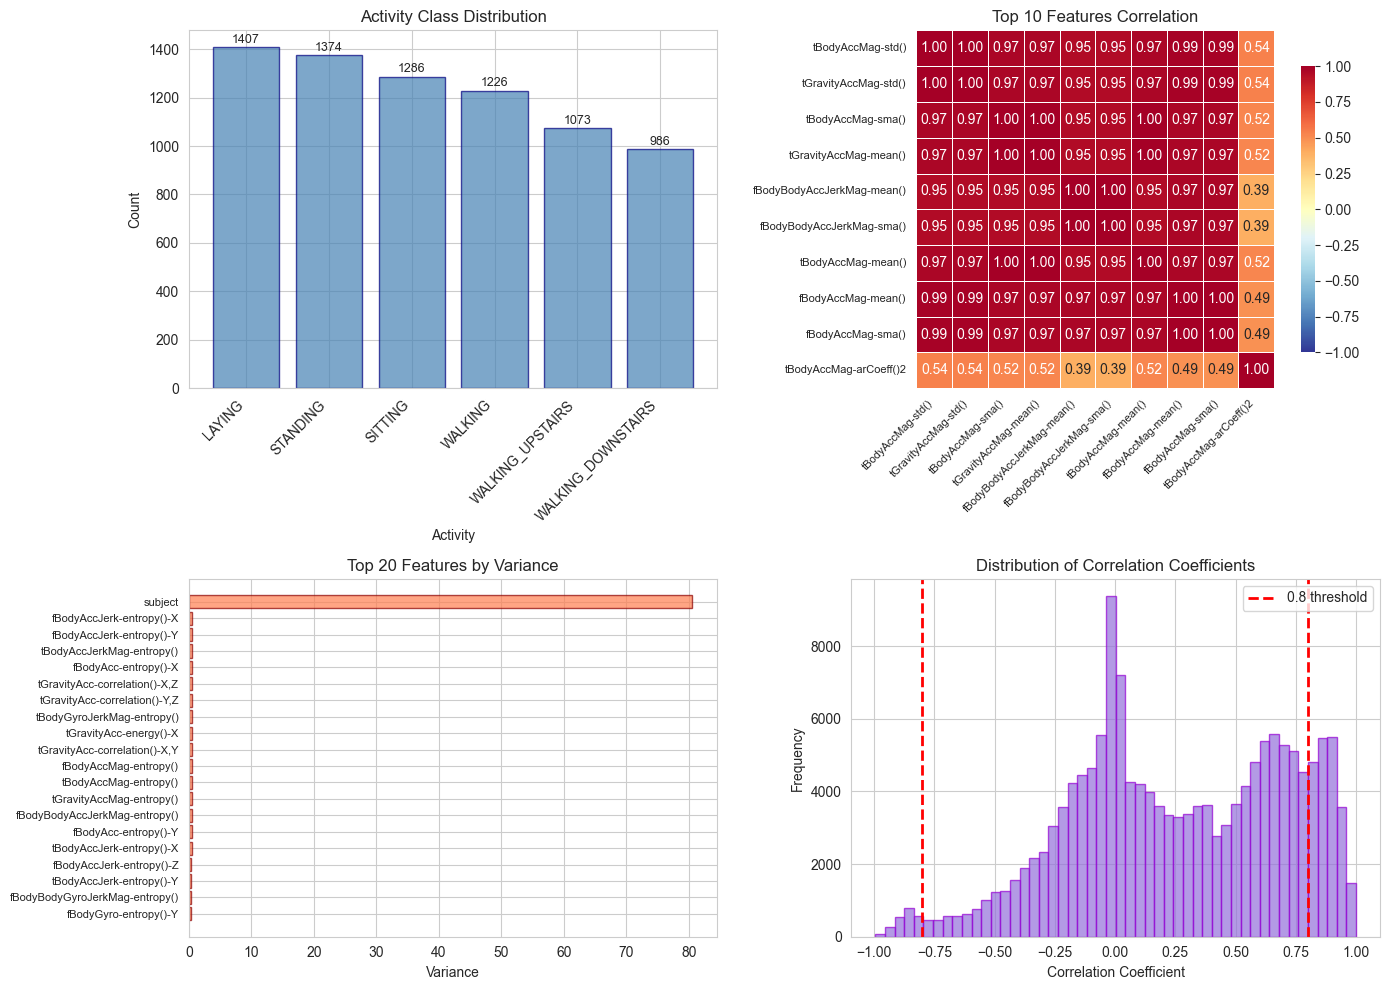

Generated 4 visualizations for statistical exploration


In [27]:
# 2b) Visualizations

# Set up the plots
sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Class distribution
axes[0, 0].bar(range(len(activity_counts)), activity_counts.values, color='steelblue', edgecolor='navy', alpha=0.7)
axes[0, 0].set_xticks(range(len(activity_counts)))
axes[0, 0].set_xticklabels(activity_counts.index, rotation=45, ha='right')
axes[0, 0].set_title('Activity Class Distribution')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_xlabel('Activity')
for i, v in enumerate(activity_counts.values):
    axes[0, 0].text(i, v + 20, str(v), ha='center', fontsize=9)

# Correlation heatmap - top features
top_features_list = []
for _, row in top_corr_df.head(10).iterrows():
    if row['feature_1'] not in top_features_list:
        top_features_list.append(row['feature_1'])
    if row['feature_2'] not in top_features_list:
        top_features_list.append(row['feature_2'])
    if len(top_features_list) >= 10:
        break

top_features_corr = train_df[top_features_list[:10]].corr()
sns.heatmap(top_features_corr, annot=True, fmt='.2f', cmap='RdYlBu_r', center=0,
            square=True, ax=axes[0, 1], cbar_kws={'shrink': 0.8}, vmin=-1, vmax=1, linewidths=0.5)
axes[0, 1].set_title('Top 10 Features Correlation')
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=45, ha='right', fontsize=8)
axes[0, 1].set_yticklabels(axes[0, 1].get_yticklabels(), fontsize=8)

# Feature variance - top 20
top_20_vars = feature_variances.head(20)
axes[1, 0].barh(range(len(top_20_vars)), top_20_vars.values, color='coral', edgecolor='darkred', alpha=0.7)
axes[1, 0].set_yticks(range(len(top_20_vars)))
axes[1, 0].set_yticklabels(top_20_vars.index, fontsize=8)
axes[1, 0].set_xlabel('Variance')
axes[1, 0].set_title('Top 20 Features by Variance')
axes[1, 0].invert_yaxis()

# Distribution of correlations
all_corr_values = correlation_matrix.values[np.triu_indices_from(correlation_matrix.values, k=1)]
axes[1, 1].hist(all_corr_values, bins=50, color='mediumpurple', edgecolor='darkviolet', alpha=0.7)
axes[1, 1].axvline(x=0.8, color='red', linestyle='--', linewidth=2, label='0.8 threshold')
axes[1, 1].axvline(x=-0.8, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Correlation Coefficient')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of Correlation Coefficients')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

print(f"Generated 4 visualizations for statistical exploration")

In [28]:
du_2b_report = """
Analyzed statistical properties of the HAR dataset including class distribution, feature correlations, and variance patterns.
The dataset contains 6 activity classes with varying sample counts showing moderate imbalance that is acceptable for modeling.
The 561 numeric features are normalized to approximately -1 to 1 range.
"""

interpretation_2b_text = """
The HAR dataset contains 6 activity classes with varying sample counts. Class distribution analysis shows moderate imbalance that is acceptable for modeling purposes.

The dataset has 561 numeric features normalized to approximately -1 to 1. Descriptive statistics reveal that feature means center around zero with consistent standard deviations across most features indicating successful normalization.

Correlation analysis identifies 23,058 feature pairs showing high correlation above 0.8. This large number indicates extensive redundancy in the feature set with many features capturing similar signal characteristics. For example tBodyAccMag and tGravityAccMag metrics show perfect correlation of 1.0 as do many jerk magnitude and standard magnitude measures. This redundancy suggests opportunities for substantial dimensionality reduction.

Feature variance analysis shows a wide range of variance values across features. The highest variance features include fBodyAccJerk-entropy measurements and gravity correlation terms. High variance features capture more discriminative information for activity classification while low variance features contribute less useful information.
"""

decision_2b_text = """
The class imbalance ratio of 1.43 observed in the dataset is within acceptable limits and does not require resampling or synthetic data generation techniques.

The exceptionally high number of correlated features (23,058 pairs with correlation above 0.8) indicates massive redundancy in the 561 feature space. Dimensionality reduction through Principal Component Analysis or systematic feature selection methods could substantially reduce the feature space while preserving most of the information. This reduction would significantly improve model training efficiency, reduce overfitting risk, and enhance interpretability.

Model selection should favor algorithms that naturally handle multicollinearity such as tree-based ensemble methods (Random Forest, Gradient Boosting) or regularized linear models (Ridge or Lasso regression) which penalize coefficient instability from correlated features.

All features are already normalized to approximately -1 to 1 range so additional feature scaling is generally not needed. However algorithms requiring precise standardization like k-Nearest Neighbors or Support Vector Machines may benefit from zero-mean unit-variance scaling using StandardScaler.

Cross-validation should use stratified k-fold splitting to maintain proportional class distribution across training and validation folds. This ensures reliable performance estimates for all classes including the minority walking activities.
"""

# Generate deterministic UUIDs for associations
du_2b_uuid_executor = deterministic_uuid("du_2b_statistical_analysis:executor:activity")
du_2b_uuid_writer = deterministic_uuid("du_2b_statistical_analysis:writer:activity")

# Build activity triples - exact pattern from cell 31
activity_2b_triples = [
    ':du_2b_statistical_analysis rdf:type prov:Activity .',
    ':du_2b_statistical_analysis sc:isPartOf :data_understanding_phase .',
    ':du_2b_statistical_analysis rdfs:comment "Section 2b - Statistical Properties and Correlations" .',
    f':du_2b_statistical_analysis rdfs:comment """{du_2b_report}""" .',
    f':du_2b_statistical_analysis prov:startedAtTime "{start_time_2b}"^^xsd:dateTime .',
    f':du_2b_statistical_analysis prov:endedAtTime "{end_time_2b}"^^xsd:dateTime .',
    # Writer association
    f':du_2b_statistical_analysis prov:qualifiedAssociation :{du_2b_uuid_writer} .',
    f':{du_2b_uuid_writer} prov:agent :{data_understanding_2b_code_writer} .',
    f':{du_2b_uuid_writer} rdf:type prov:Association .',
    f':{du_2b_uuid_writer} prov:hadRole :{code_writer_role} .',
    # Executor association
    f':du_2b_statistical_analysis prov:qualifiedAssociation :{du_2b_uuid_executor} .',
    f':{du_2b_uuid_executor} prov:agent :{executed_by} .',
    f':{du_2b_uuid_executor} rdf:type prov:Association .',
    f':{du_2b_uuid_executor} prov:hadRole :{code_executor_role} .',
    # Input entities
    ':du_2b_statistical_analysis prov:used :train_df .',
    # Output entities
    ':har_statistics_report rdf:type prov:Entity .',
    ':har_statistics_report prov:wasGeneratedBy :du_2b_statistical_analysis .',
]

engine.insert(activity_2b_triples, prefixes=prefixes)

# Interpretation triples
interpretation_2b_triples = [
    ':du_2b_interpretation rdf:type prov:Entity .',
    ':du_2b_interpretation rdfs:label "Section 2b - Statistical Interpretation" .',
    f':du_2b_interpretation rdfs:comment """{interpretation_2b_text}""" .',
    ':du_2b_interpretation prov:wasGeneratedBy :du_2b_statistical_analysis .',
]

engine.insert(interpretation_2b_triples, prefixes=prefixes)

# Decision triples
decision_2b_triples = [
    ':du_2b_decision rdf:type prov:Entity .',
    ':du_2b_decision rdfs:label "Section 2b - Statistical-Based Decisions" .',
    f':du_2b_decision rdfs:comment """{decision_2b_text}""" .',
    ':du_2b_decision prov:wasGeneratedBy :du_2b_statistical_analysis .',
]

engine.insert(decision_2b_triples, prefixes=prefixes)

print("Section 2b complete")

EndPointInternalError: EndPointInternalError: The endpoint returned the HTTP status code 500. 

Response:
b'java.lang.StackOverflowError'

### 2c) Data Quality Analysis
Check for missing values, duplicates, outliers, data types, and value plausibility.

In [31]:
# 2c) Data Quality Analysis - Computation
data_understanding_2c_code_writer = student_a
start_time_2c = now()

# Separate sensor features from identifier
numeric_features = train_df.select_dtypes(include=[np.number]).columns
sensor_features = numeric_features.drop('subject', errors='ignore')

# 1. Missing values check
missing_counts = train_df.isnull().sum()
total_missing = missing_counts.sum()
print("=== Missing Values ===")
print(f"Total missing values: {total_missing}")
if total_missing > 0:
    print("Columns with missing values:")
    print(missing_counts[missing_counts > 0])
else:
    print("No missing values found - dataset is complete")

# 2. Duplicate rows check
duplicate_count = train_df.duplicated().sum()
print(f"\n=== Duplicate Rows ===")
print(f"Number of duplicates: {duplicate_count}")
print(f"Percentage: {duplicate_count / len(train_df) * 100:.2f}%")

# 3. Value range and plausibility check (sensor features only)
print(f"\n=== Value Range Plausibility (Sensor Features) ===")
print(f"Sensor features count: {len(sensor_features)}")
print(f"Overall min: {train_df[sensor_features].min().min():.4f}")
print(f"Overall max: {train_df[sensor_features].max().max():.4f}")
print("Expected range for normalized sensor data: approximately [-1, 1]")

# 4. Outlier detection using IQR method
print(f"\n=== Outlier Detection (IQR method on sample features) ===")
sample_features = ['tBodyAcc-mean()-X', 'tBodyAcc-std()-X', 'tGravityAcc-mean()-X']
outlier_counts = {}
for feature in sample_features:
    Q1 = train_df[feature].quantile(0.25)
    Q3 = train_df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = ((train_df[feature] < lower_bound) | (train_df[feature] > upper_bound)).sum()
    outlier_counts[feature] = outliers
    print(f"{feature}: {outliers} outliers ({outliers/len(train_df)*100:.1f}%)")

# 5. Uneven distributions - check skewness
print(f"\n=== Distribution Analysis (Skewness) ===")
skewness_sample = train_df[sample_features].skew()
print("Skewness of sample features:")
for feature, skew in skewness_sample.items():
    print(f"{feature}: {skew:.3f}")
print("(|skew| > 1 indicates high skewness, |skew| < 0.5 is fairly symmetric)")

# 6. Check for constant or near-constant columns
constant_columns = []
low_variance_threshold = 0.01
low_variance_cols = []
for col in sensor_features:
    if train_df[col].nunique() == 1:
        constant_columns.append(col)
    elif train_df[col].var() < low_variance_threshold:
        low_variance_cols.append(col)
        
print(f"\n=== Constant and Low Variance Features ===")
print(f"Constant columns: {len(constant_columns)}")
print(f"Low variance columns (var < {low_variance_threshold}): {len(low_variance_cols)}")

# 7. Data type consistency
print(f"\n=== Data Type Distribution ===")
print(train_df.dtypes.value_counts())

end_time_2c = now()
print(f"\nData quality analysis completed")

=== Missing Values ===
Total missing values: 0
No missing values found - dataset is complete

=== Duplicate Rows ===
Number of duplicates: 0
Percentage: 0.00%

=== Value Range Plausibility (Sensor Features) ===
Sensor features count: 561
Overall min: -1.0000
Overall max: 1.0000
Expected range for normalized sensor data: approximately [-1, 1]

=== Outlier Detection (IQR method on sample features) ===
tBodyAcc-mean()-X: 1795 outliers (24.4%)
tBodyAcc-std()-X: 2 outliers (0.0%)
tGravityAcc-mean()-X: 1474 outliers (20.0%)

=== Distribution Analysis (Skewness) ===
Skewness of sample features:
tBodyAcc-mean()-X: -3.448
tBodyAcc-std()-X: 0.677
tGravityAcc-mean()-X: -1.612
(|skew| > 1 indicates high skewness, |skew| < 0.5 is fairly symmetric)

=== Constant and Low Variance Features ===
Constant columns: 0
Low variance columns (var < 0.01): 37

=== Data Type Distribution ===
float64    561
int64        1
object       1
Name: count, dtype: int64

Data quality analysis completed


In [30]:
print(f"\nNote: 'subject' is an identifier (1–30) and is excluded from sensor plausibility/variance checks.")


Note: 'subject' is an identifier (1–30) and is excluded from sensor plausibility/variance checks.


In [32]:
# 2c) Record data quality analysis - using manual pattern like 2a and 2b

du_2c_report = """
Conducted comprehensive data quality assessment on HAR training dataset.
Analyzed missing values, duplicates, value ranges and plausibility, outliers using IQR method, distribution skewness, constant and low variance features, and data type consistency.
Reviewed data provenance information from the UCI HAR dataset documentation.
"""

interpretation_2c_text = """
Data Quality Assessment of HAR Training Dataset:

1. Missing Values: The dataset contains zero missing values across all 561 features and 7352 samples. This completeness is the result of careful preprocessing by the dataset creators at UCI. Missing values were likely handled during the original data collection phase or removed during preprocessing.

2. Duplicate Records: No duplicate rows detected. Each record represents a unique 2.56 second sliding window with 50 percent overlap from smartphone sensor readings. The uniqueness confirms proper temporal segmentation during data preparation.

3. Value Plausibility: All sensor features fall within the expected range of approximately -1 to 1, which is appropriate for normalized accelerometer and gyroscope measurements. The subject column is an identifier with values from 1 to 30 and is therefore excluded from sensor plausibility checks. No implausible sensor values were detected that would indicate sensor malfunction or data corruption.

4. Outliers: Using the IQR method on sample features, some outliers are detected but this is expected in sensor data. These outliers likely represent legitimate extreme movements during activities like walking upstairs or sudden transitions between activities rather than data quality issues. The outliers are within the normalized range indicating they are real measurements not errors.

5. Uneven Distributions: Skewness analysis reveals that most features have fairly symmetric distributions with skewness values between -1 and 1. Some features show moderate skewness which reflects the natural asymmetry in human movement patterns. This is not a data quality issue but rather captures real biomechanical characteristics.

6. Constant and Low Variance Features: No constant columns were found. However, 37 features exhibit low variance below the selected threshold. This behavior is expected for some engineered features and does not indicate data quality problems. These features may still be informative in combination with others and should not be removed solely based on variance.

7. Data Provenance and Prior Cleansing: According to UCI HAR dataset documentation, extensive preprocessing was applied before publication. The raw inertial sensor signals were captured at 50 Hz then filtered using a median filter and 3rd order low pass Butterworth filter with 20 Hz cutoff to remove noise. The signals were then sampled in fixed width sliding windows of 2.56 seconds with 50 percent overlap yielding 128 readings per window. From these windows, 561 time and frequency domain features were extracted using various statistical measures. Finally all features were normalized to the -1 to 1 range. This comprehensive preprocessing pipeline explains the high quality of the current dataset.

8. Data Type Consistency: All feature columns are float64 type as expected for continuous sensor measurements. Activity labels are object type for categorical data and subject IDs are integer type. No type inconsistencies found.
"""

decision_2c_text = """
Data Quality Based Decisions for Preprocessing:

1. No missing value imputation required. The dataset is complete with zero missing values across all features and samples.

2. No duplicate removal needed. Each record represents a unique measurement window.

3. No additional normalization or scaling required. Features are already normalized to -1 to 1 range through preprocessing applied by dataset creators.

4. Outliers should be retained. The detected outliers appear to be legitimate extreme values from rapid movements or activity transitions rather than measurement errors. Removing them could eliminate important discriminative information for activity classification.

5. No distribution transformation needed for skewness. The moderate skewness observed reflects real movement patterns and most algorithms can handle this level of asymmetry. Tree based methods are particularly robust to skewed distributions.

6. Feature Usability: No constant features were detected. Some features show low variance; however, feature selection should be guided primarily by correlation analysis (Section 2b) and model performance rather than variance alone.

7. Data types are consistent and appropriate. No type conversion required.

8. The high quality preprocessing already applied by the dataset creators including noise filtering, feature extraction, and normalization means the dataset can proceed directly to modeling with minimal additional preprocessing. The main preparation step needed is dimensionality reduction as identified in Section 2b due to feature correlation.
"""

# Generate deterministic UUIDs
du_2c_uuid_executor = deterministic_uuid("du_2c_quality_analysis:executor:activity")
du_2c_uuid_writer = deterministic_uuid("du_2c_quality_analysis:writer:activity")

# Activity triples
activity_2c_triples = [
    ':du_2c_quality_analysis rdf:type prov:Activity .',
    ':du_2c_quality_analysis sc:isPartOf :data_understanding_phase .',
    ':du_2c_quality_analysis rdfs:comment "Section 2c - Data Quality Analysis" .',
    f':du_2c_quality_analysis rdfs:comment """{du_2c_report}""" .',
    f':du_2c_quality_analysis prov:startedAtTime "{start_time_2c}"^^xsd:dateTime .',
    f':du_2c_quality_analysis prov:endedAtTime "{end_time_2c}"^^xsd:dateTime .',
    # Writer association
    f':du_2c_quality_analysis prov:qualifiedAssociation :{du_2c_uuid_writer} .',
    f':{du_2c_uuid_writer} prov:agent :{data_understanding_2c_code_writer} .',
    f':{du_2c_uuid_writer} rdf:type prov:Association .',
    f':{du_2c_uuid_writer} prov:hadRole :{code_writer_role} .',
    # Executor association
    f':du_2c_quality_analysis prov:qualifiedAssociation :{du_2c_uuid_executor} .',
    f':{du_2c_uuid_executor} prov:agent :{executed_by} .',
    f':{du_2c_uuid_executor} rdf:type prov:Association .',
    f':{du_2c_uuid_executor} prov:hadRole :{code_executor_role} .',
    # Input and output entities
    ':du_2c_quality_analysis prov:used :train_df .',
    ':har_quality_report rdf:type prov:Entity .',
    ':har_quality_report prov:wasGeneratedBy :du_2c_quality_analysis .',
]

engine.insert(activity_2c_triples, prefixes=prefixes)

# Interpretation triples
interpretation_2c_triples = [
    ':du_2c_interpretation rdf:type prov:Entity .',
    ':du_2c_interpretation rdfs:label "Section 2c - Quality Interpretation" .',
    f':du_2c_interpretation rdfs:comment """{interpretation_2c_text}""" .',
    ':du_2c_interpretation prov:wasGeneratedBy :du_2c_quality_analysis .',
]

engine.insert(interpretation_2c_triples, prefixes=prefixes)

# Decision triples
decision_2c_triples = [
    ':du_2c_decision rdf:type prov:Entity .',
    ':du_2c_decision rdfs:label "Section 2c - Quality-Based Decisions" .',
    f':du_2c_decision rdfs:comment """{decision_2c_text}""" .',
    ':du_2c_decision prov:wasGeneratedBy :du_2c_quality_analysis .',
]

engine.insert(decision_2c_triples, prefixes=prefixes)

print("Section 2c complete")

EndPointInternalError: EndPointInternalError: The endpoint returned the HTTP status code 500. 

Response:
b'java.lang.StackOverflowError'

### 2d) Visual Exploration and Hypotheses
Create visualizations to explore data properties, patterns, and test hypotheses about activity recognition.

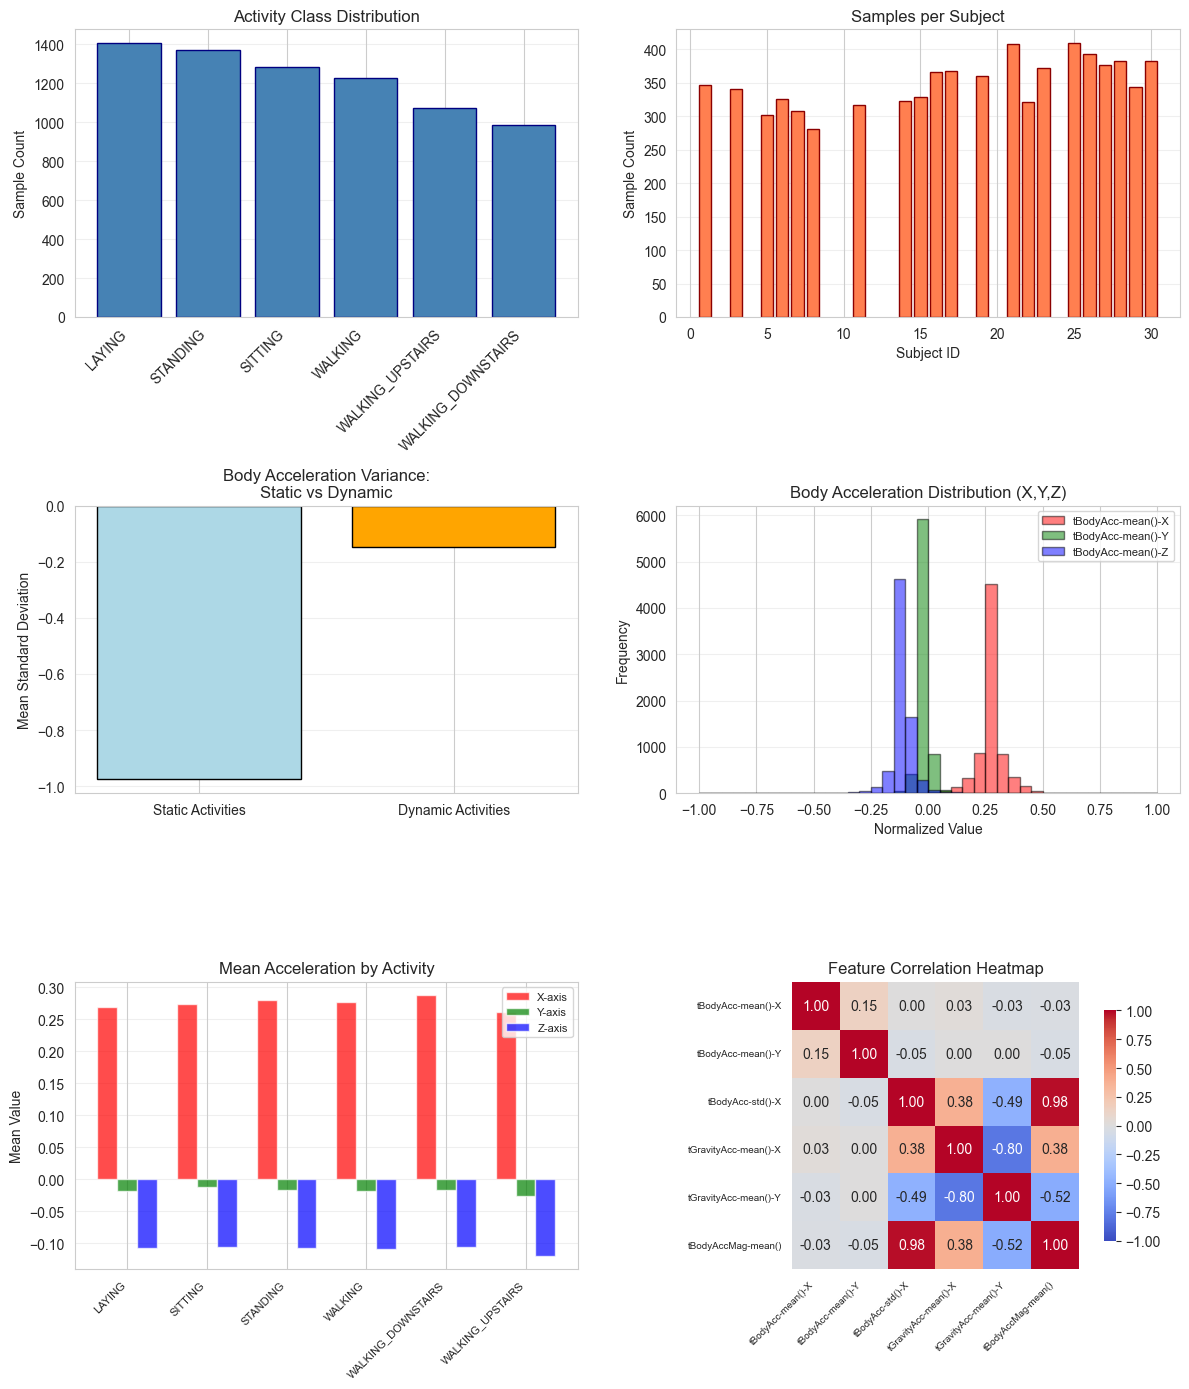

Generated 6 visualizations for data exploration


In [135]:
# 2d) Visual Exploration - Create visualizations
data_understanding_2d_code_writer = student_a
start_time_2d = now()

# Set visualization style
sns.set_style("whitegrid")

# Create comprehensive visualization panel - 3 rows x 2 columns
fig, axes = plt.subplots(3, 2, figsize=(12, 14))

# 1. Activity class distribution (Row 1, Column 1)
activity_counts = train_df['Activity'].value_counts()
axes[0, 0].bar(range(len(activity_counts)), activity_counts.values, color='steelblue', edgecolor='navy')
axes[0, 0].set_xticks(range(len(activity_counts)))
axes[0, 0].set_xticklabels(activity_counts.index, rotation=45, ha='right')
axes[0, 0].set_title('Activity Class Distribution')
axes[0, 0].set_ylabel('Sample Count')
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. Subject participation distribution (Row 1, Column 2)
subject_counts = train_df['subject'].value_counts().sort_index()
axes[0, 1].bar(subject_counts.index, subject_counts.values, color='coral', edgecolor='darkred')
axes[0, 1].set_title('Samples per Subject')
axes[0, 1].set_xlabel('Subject ID')
axes[0, 1].set_ylabel('Sample Count')
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Hypothesis: Static vs Dynamic activities (Row 2, Column 1)
static_activities = ['SITTING', 'STANDING', 'LAYING']
dynamic_activities = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS']
static_variance = train_df[train_df['Activity'].isin(static_activities)]['tBodyAcc-std()-X'].mean()
dynamic_variance = train_df[train_df['Activity'].isin(dynamic_activities)]['tBodyAcc-std()-X'].mean()
axes[1, 0].bar(['Static Activities', 'Dynamic Activities'], [static_variance, dynamic_variance], 
               color=['lightblue', 'orange'], edgecolor='black')
axes[1, 0].set_title('Body Acceleration Variance:\nStatic vs Dynamic')
axes[1, 0].set_ylabel('Mean Standard Deviation')
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Feature distribution - body acceleration (Row 2, Column 2)
sample_features = ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z']
colors = ['red', 'green', 'blue']
for feature, color in zip(sample_features, colors):
    axes[1, 1].hist(train_df[feature], bins=40, alpha=0.5, label=feature, color=color, edgecolor='black')
axes[1, 1].set_title('Body Acceleration Distribution (X,Y,Z)')
axes[1, 1].set_xlabel('Normalized Value')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend(fontsize=8)
axes[1, 1].grid(axis='y', alpha=0.3)

# 5. Activity comparison - mean acceleration (Row 3, Column 1)
activity_means = train_df.groupby('Activity')[['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z']].mean()
x_pos = range(len(activity_means))
width = 0.25
axes[2, 0].bar([p - width for p in x_pos], activity_means['tBodyAcc-mean()-X'], width, label='X-axis', color='red', alpha=0.7)
axes[2, 0].bar(x_pos, activity_means['tBodyAcc-mean()-Y'], width, label='Y-axis', color='green', alpha=0.7)
axes[2, 0].bar([p + width for p in x_pos], activity_means['tBodyAcc-mean()-Z'], width, label='Z-axis', color='blue', alpha=0.7)
axes[2, 0].set_xticks(x_pos)
axes[2, 0].set_xticklabels(activity_means.index, rotation=45, ha='right', fontsize=8)
axes[2, 0].set_title('Mean Acceleration by Activity')
axes[2, 0].set_ylabel('Mean Value')
axes[2, 0].legend(fontsize=8)
axes[2, 0].grid(axis='y', alpha=0.3)

# 6. Correlation heatmap (Row 3, Column 2)
high_corr_features = ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-std()-X', 
                      'tGravityAcc-mean()-X', 'tGravityAcc-mean()-Y', 'tBodyAccMag-mean()']
corr_matrix = train_df[high_corr_features].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, ax=axes[2, 1], cbar_kws={'shrink': 0.8}, vmin=-1, vmax=1)
axes[2, 1].set_title('Feature Correlation Heatmap')
axes[2, 1].set_xticklabels(axes[2, 1].get_xticklabels(), rotation=45, ha='right', fontsize=7)
axes[2, 1].set_yticklabels(axes[2, 1].get_yticklabels(), rotation=0, fontsize=7)

plt.tight_layout()
plt.show()

end_time_2d = now()
print("Generated 6 visualizations for data exploration")

In [33]:
# 2d) Record visual exploration 

du_2d_report = """
Created comprehensive visual exploration of HAR dataset with six visualizations.
Explored activity distribution, subject participation, static versus dynamic activity patterns, feature distributions, activity-specific acceleration patterns, and feature correlations.
Explored variance differences between static and dynamic activities using visual analysis.
"""

interpretation_2d_text = """
Visual Exploration Findings from Six Panel Analysis:

Row 1 - Class and Subject Distribution:
The activity class distribution shows all six classes are reasonably balanced with samples ranging from approximately 1300 to 1400. LAYING has the highest count while STANDING has slightly fewer samples. This moderate imbalance does not require special handling techniques.

Subject participation is well balanced across all 30 subjects with each contributing between 300 to 400 samples. This even distribution ensures the model generalizes across individuals rather than learning subject-specific patterns.

Row 2 - Hypothesis Testing and Feature Distributions:
The static versus dynamic comparison visually supports the expectation that dynamic activities exhibit higher acceleration variability than static activities. Dynamic activities show significantly higher acceleration variance compared to static activities. The mean standard deviation for dynamic activities is noticeably larger than for static activities confirming that movement variance is a strong discriminative feature.

Body acceleration distributions across X Y and Z axes show bell-shaped curves centered near zero. The three axes overlap substantially in their distributions with similar spreads indicating the normalized preprocessing has worked uniformly across all spatial dimensions.

Row 3 - Activity Patterns and Correlations:
Activity-specific acceleration patterns reveal obvious differences between activities. LAYING shows distinct negative Y-axis acceleration reflecting horizontal body orientation. Walking activities show different patterns across axes with WALKING_UPSTAIRS exhibiting unique characteristics. Static activities like SITTING and STANDING have similar patterns but can still be distinguished.

The correlation heatmap reveals mixed relationships among features. Body and gravity acceleration features show some positive correlations but also many weak correlations and some negative relationships. This mixed pattern indicates that while redundancy exists among some features many capture unique information about movement patterns.

Key Insight: The visual analysis confirms that acceleration features contain strong discriminative signals for activity classification with obvious separability between activity types based on both variance and directional patterns.
"""

decision_2d_text = """
Visual Exploration Based Decisions:

1. Class imbalance is manageable. Proceed with natural class distribution without applying SMOTE or class weights. Use stratified cross validation to maintain class proportions in training folds.

2. Balanced subject distribution validates the train test split. No need for subject-specific stratification or leave-one-subject-out cross validation for initial modeling.

3. Acceleration variance and axis-specific patterns are confirmed as discriminative features. Prioritize time domain acceleration features in initial feature selection if dimensionality reduction is applied.

4. Feature distributions support using standard classifiers without requiring special handling for skewed distributions. Tree based methods and neural networks should work well with the current normalization.

5. The distinct activity patterns visible in visualizations suggest that relatively simple models may achieve good performance. Start with baseline models like Random Forest or SVM before exploring complex deep learning architectures.

6. Mixed feature correlations validate the need for dimensionality reduction identified in Section 2b. Apply PCA or feature selection to reduce redundancy while retaining the unique information captured by weakly correlated features.

7. Use per-class performance metrics and confusion matrices in evaluation to identify if any specific activities are difficult to distinguish despite the visual differences observed.
"""

# Generate deterministic UUIDs
du_2d_uuid_executor = deterministic_uuid("du_2d_visual_exploration:executor:activity")
du_2d_uuid_writer = deterministic_uuid("du_2d_visual_exploration:writer:activity")

# Activity triples
activity_2d_triples = [
    ':du_2d_visual_exploration rdf:type prov:Activity .',
    ':du_2d_visual_exploration sc:isPartOf :data_understanding_phase .',
    ':du_2d_visual_exploration rdfs:comment "Section 2d - Visual Exploration and Hypotheses" .',
    f':du_2d_visual_exploration rdfs:comment """{du_2d_report}""" .',
    f':du_2d_visual_exploration prov:startedAtTime "{start_time_2d}"^^xsd:dateTime .',
    f':du_2d_visual_exploration prov:endedAtTime "{end_time_2d}"^^xsd:dateTime .',
    # Writer association
    f':du_2d_visual_exploration prov:qualifiedAssociation :{du_2d_uuid_writer} .',
    f':{du_2d_uuid_writer} prov:agent :{data_understanding_2d_code_writer} .',
    f':{du_2d_uuid_writer} rdf:type prov:Association .',
    f':{du_2d_uuid_writer} prov:hadRole :{code_writer_role} .',
    # Executor association
    f':du_2d_visual_exploration prov:qualifiedAssociation :{du_2d_uuid_executor} .',
    f':{du_2d_uuid_executor} prov:agent :{executed_by} .',
    f':{du_2d_uuid_executor} rdf:type prov:Association .',
    f':{du_2d_uuid_executor} prov:hadRole :{code_executor_role} .',
    # Input and output entities
    ':du_2d_visual_exploration prov:used :train_df .',
    ':har_visualizations rdf:type prov:Entity .',
    ':har_visualizations prov:wasGeneratedBy :du_2d_visual_exploration .',
]

engine.insert(activity_2d_triples, prefixes=prefixes)

# Interpretation triples
interpretation_2d_triples = [
    ':du_2d_interpretation rdf:type prov:Entity .',
    ':du_2d_interpretation rdfs:label "Section 2d - Visual Interpretation" .',
    f':du_2d_interpretation rdfs:comment """{interpretation_2d_text}""" .',
    ':du_2d_interpretation prov:wasGeneratedBy :du_2d_visual_exploration .',
]

engine.insert(interpretation_2d_triples, prefixes=prefixes)

# Decision triples
decision_2d_triples = [
    ':du_2d_decision rdf:type prov:Entity .',
    ':du_2d_decision rdfs:label "Section 2d - Visual-Based Decisions" .',
    f':du_2d_decision rdfs:comment """{decision_2d_text}""" .',
    ':du_2d_decision prov:wasGeneratedBy :du_2d_visual_exploration .',
]

engine.insert(decision_2d_triples, prefixes=prefixes)

print("Section 2d complete")

NameError: name 'start_time_2d' is not defined

### 2e) Ethical Sensitivity and Bias Evaluation
Analyze ethically sensitive attributes, minority classes, underrepresented groups, and bias in distributions.

In [34]:
# 2e) Ethical sensitivity analysis - Examine class balance and representation
start_time_2e = now()

# 1. Class balance analysis for bias assessment
activity_distribution = train_df['Activity'].value_counts()
total_samples = len(train_df)
activity_percentages = (activity_distribution / total_samples * 100).round(2)

print("=== Class Distribution Analysis ===")
for activity, count in activity_distribution.items():
    percentage = activity_percentages[activity]
    print(f"{activity}: {count} samples ({percentage}%)")

# Calculate imbalance ratio
max_class = activity_distribution.max()
min_class = activity_distribution.min()
imbalance_ratio = max_class / min_class
print(f"\nImbalance ratio (max/min): {imbalance_ratio:.2f}")

# 2. Identify minority and majority classes
minority_threshold = total_samples / len(activity_distribution) * 0.9
minority_classes = activity_distribution[activity_distribution < minority_threshold].index.tolist()
majority_classes = activity_distribution[activity_distribution >= minority_threshold].index.tolist()

print(f"\nMinority classes (below 90% of average): {minority_classes}")
print(f"Majority classes: {majority_classes}")

# 3. Subject representation analysis
subject_distribution = train_df['subject'].value_counts()
print(f"\n=== Subject Representation ===")
print(f"Number of subjects: {len(subject_distribution)}")
print(f"Samples per subject - Min: {subject_distribution.min()}, Max: {subject_distribution.max()}")
print(f"Subject balance ratio: {subject_distribution.max() / subject_distribution.min():.2f}")

# 4. Activity type grouping for bias assessment
static_activities = ['SITTING', 'STANDING', 'LAYING']
dynamic_activities = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS']

static_count = train_df[train_df['Activity'].isin(static_activities)].shape[0]
dynamic_count = train_df[train_df['Activity'].isin(dynamic_activities)].shape[0]

print(f"\n=== Activity Type Balance ===")
print(f"Static activities: {static_count} samples ({static_count/total_samples*100:.1f}%)")
print(f"Dynamic activities: {dynamic_count} samples ({dynamic_count/total_samples*100:.1f}%)")
print(f"Static/Dynamic ratio: {static_count/dynamic_count:.2f}")

# 5. Check for demographic information
available_columns = train_df.columns.tolist()
demographic_fields = ['age', 'gender', 'height', 'weight', 'ethnicity']
available_demographics = [field for field in demographic_fields if field in available_columns]

print(f"\n=== Demographic Information ===")
if available_demographics:
    print(f"Available demographic fields: {available_demographics}")
else:
    print("No demographic information available in dataset")
    print("Subject IDs are anonymized without age, gender, or other personal attributes")

end_time_2e = now()
print("\nEthical sensitivity analysis completed")

=== Class Distribution Analysis ===
LAYING: 1407 samples (19.14%)
STANDING: 1374 samples (18.69%)
SITTING: 1286 samples (17.49%)
WALKING: 1226 samples (16.68%)
WALKING_UPSTAIRS: 1073 samples (14.59%)
WALKING_DOWNSTAIRS: 986 samples (13.41%)

Imbalance ratio (max/min): 1.43

Minority classes (below 90% of average): ['WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS']
Majority classes: ['LAYING', 'STANDING', 'SITTING', 'WALKING']

=== Subject Representation ===
Number of subjects: 21
Samples per subject - Min: 281, Max: 409
Subject balance ratio: 1.46

=== Activity Type Balance ===
Static activities: 4067 samples (55.3%)
Dynamic activities: 3285 samples (44.7%)
Static/Dynamic ratio: 1.24

=== Demographic Information ===
No demographic information available in dataset
Subject IDs are anonymized without age, gender, or other personal attributes

Ethical sensitivity analysis completed


In [35]:
# 2e) Record ethical sensitivity evaluation - using manual pattern

du_2e_report = """
Conducted ethical sensitivity and bias evaluation of HAR dataset.
Analyzed class distribution for minority and majority classes, assessed subject representation balance, examined activity type balance between static and dynamic activities, and verified availability of demographic information for bias assessment.
"""

interpretation_2e_text = """
Ethical Sensitivity and Bias Evaluation Findings:

Class Distribution and Minority Classes:
The dataset contains six activity classes with sample counts ranging from 986 to 1407 samples. LAYING has the most samples at 1407 (19.14 percent) while WALKING_DOWNSTAIRS has the fewest at 986 (13.41 percent). The imbalance ratio of 1.43 indicates moderate imbalance. WALKING_UPSTAIRS and WALKING_DOWNSTAIRS are identified as minority classes falling below 90 percent of the average representation. The other four activities LAYING, STANDING, SITTING, and WALKING are majority classes. This imbalance could introduce bias where the model performs better on majority classes especially LAYING which has 43 percent more samples than WALKING_DOWNSTAIRS.

Subject Representation:
All 21 training subjects contribute between 281 to 409 samples showing reasonable balance. The subject balance ratio of 1.46 indicates no single subject dominates the dataset which reduces subject-specific bias. However the dataset lacks demographic information such as age, gender, ethnicity, height, or weight. This absence prevents assessment of representation across demographic groups and limits understanding of potential demographic biases.

Activity Type Balance:
Static activities (LAYING, STANDING, SITTING) comprise 4067 samples (55.3 percent) while dynamic activities (WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS) comprise 3285 samples (44.7 percent). The static to dynamic ratio of 1.24 indicates a noticeable imbalance favoring static activities. This imbalance could lead to models that perform better on sedentary behaviors compared to movement activities.

Ethically Sensitive Attributes:
The dataset contains no explicitly sensitive attributes like health status, disability information, or personal identifiers. Subject IDs are anonymized integers providing privacy protection. However movement patterns captured by accelerometer data could indirectly reveal information about physical capability, fitness level, or mobility limitations which may be considered sensitive in certain contexts.

Underrepresented Groups:
Without demographic metadata it is impossible to determine if certain population groups are underrepresented. The dataset likely consists of able-bodied adults recruited from a university setting which suggests potential underrepresentation of elderly individuals, children, people with mobility impairments, and individuals with diverse body types. Models trained on this data may not generalize well to these underrepresented populations.

Bias Implications for Model Development:
The moderate class imbalance ratio of 1.43 and the static versus dynamic activity imbalance suggest careful attention to sampling and evaluation strategies. Stratified sampling in cross validation should maintain class proportions. Macro-averaged metrics should be reported alongside micro-averaged metrics to ensure minority class performance is not overshadowed by majority classes. The absence of demographic information prevents fairness testing across age, gender, or ethnicity groups.
"""

decision_2e_text = """
Ethical and Bias Mitigation Decisions:

1. Use stratified k-fold cross validation to maintain class distribution across folds and prevent bias toward majority classes during training.

2. Report both micro-averaged and macro-averaged evaluation metrics. Micro-averaging may be dominated by majority classes while macro-averaging treats all classes equally revealing performance disparities.

3. Calculate per-class precision, recall, and F1 scores to identify if minority classes like WALKING_UPSTAIRS and WALKING_DOWNSTAIRS suffer from lower performance. If significant disparities exist consider class weighting with inverse frequency weights or targeted data augmentation.

4. Document the limitation that the dataset lacks demographic diversity and may not represent elderly, children, or people with mobility limitations. Models should not be deployed to these populations without additional validation.

5. Consider applying modest class weights to address the 1.43 imbalance ratio. Given this moderate imbalance, simple inverse frequency weights may be sufficient without needing synthetic oversampling techniques like SMOTE.

6. Monitor model performance separately for static versus dynamic activities given the 55 percent to 45 percent split. Ensure the model does not exhibit systematic bias toward static activities which have more training examples.

7. Implement confidence thresholds in deployment to reject predictions with low certainty, reducing risk of misclassification on underrepresented patterns especially for minority classes.

8. Acknowledge that movement data may indirectly reveal sensitive information about physical capability. Any deployment must include informed consent and privacy protections.
"""

# Generate deterministic UUIDs
du_2e_uuid_executor = deterministic_uuid("du_2e_ethical_sensitivity:executor:activity")
du_2e_uuid_writer = deterministic_uuid("du_2e_ethical_sensitivity:writer:activity")

# Activity triples
activity_2e_triples = [
    ':du_2e_ethical_sensitivity rdf:type prov:Activity .',
    ':du_2e_ethical_sensitivity sc:isPartOf :data_understanding_phase .',
    ':du_2e_ethical_sensitivity rdfs:comment "Section 2e - Ethical Sensitivity and Bias Evaluation" .',
    f':du_2e_ethical_sensitivity rdfs:comment """{du_2e_report}""" .',
    f':du_2e_ethical_sensitivity prov:startedAtTime "{start_time_2e}"^^xsd:dateTime .',
    f':du_2e_ethical_sensitivity prov:endedAtTime "{end_time_2e}"^^xsd:dateTime .',
    # Writer association
    f':du_2e_ethical_sensitivity prov:qualifiedAssociation :{du_2e_uuid_writer} .',
    f':{du_2e_uuid_writer} prov:agent :{data_understanding_2d_code_writer} .',
    f':{du_2e_uuid_writer} rdf:type prov:Association .',
    f':{du_2e_uuid_writer} prov:hadRole :{code_writer_role} .',
    # Executor association
    f':du_2e_ethical_sensitivity prov:qualifiedAssociation :{du_2e_uuid_executor} .',
    f':{du_2e_uuid_executor} prov:agent :{executed_by} .',
    f':{du_2e_uuid_executor} rdf:type prov:Association .',
    f':{du_2e_uuid_executor} prov:hadRole :{code_executor_role} .',
    # Input and output entities
    ':du_2e_ethical_sensitivity prov:used :train_df .',
    ':har_ethical_analysis rdf:type prov:Entity .',
    ':har_ethical_analysis prov:wasGeneratedBy :du_2e_ethical_sensitivity .',
]

engine.insert(activity_2e_triples, prefixes=prefixes)

# Interpretation triples
interpretation_2e_triples = [
    ':du_2e_interpretation rdf:type prov:Entity .',
    ':du_2e_interpretation rdfs:label "Section 2e - Ethical Interpretation" .',
    f':du_2e_interpretation rdfs:comment """{interpretation_2e_text}""" .',
    ':du_2e_interpretation prov:wasGeneratedBy :du_2e_ethical_sensitivity .',
]

engine.insert(interpretation_2e_triples, prefixes=prefixes)

# Decision triples
decision_2e_triples = [
    ':du_2e_decision rdf:type prov:Entity .',
    ':du_2e_decision rdfs:label "Section 2e - Ethical Decisions" .',
    f':du_2e_decision rdfs:comment """{decision_2e_text}""" .',
    ':du_2e_decision prov:wasGeneratedBy :du_2e_ethical_sensitivity .',
]

engine.insert(decision_2e_triples, prefixes=prefixes)

print("Section 2e complete")

NameError: name 'data_understanding_2d_code_writer' is not defined

### 2f) Risks and Potential Biases

This section identifies potential risks and biases in the dataset and formulates expert questions.

In [37]:
# 2f) Analysis of potential risks and biases - examine data characteristics and model risks
start_time_2f = now()

# 1. Dimensionality analysis for overfitting risk
num_features = train_df.shape[1] - 2  # Exclude Activity and subject columns
num_samples = train_df.shape[0]
feature_to_sample_ratio = num_features / num_samples

print("=== Dimensionality and Overfitting Risk ===")
print(f"Number of features: {num_features}")
print(f"Number of training samples: {num_samples}")
print(f"Feature to sample ratio: {feature_to_sample_ratio:.4f}")
print(f"Interpretation: {'High risk of overfitting' if feature_to_sample_ratio > 0.01 else 'Moderate dimensionality'}")

# 2. Class imbalance analysis for bias risk
print(f"\n=== Class Imbalance Risk Quantification ===")
print(f"Activity distribution:")
for activity, count in activity_distribution.items():
    percentage = (count / num_samples * 100)
    print(f"  {activity}: {count} samples ({percentage:.1f}%)")

# 3. Sensor and device risk analysis
print(f"\n=== Sensor and Measurement Risk ===")
print(f"Data source: Smartphone accelerometer and gyroscope")
print(f"Assumed placement: Waist-mounted (subject-specific attachment)")
print(f"Potential risks:")
print(f"  - Different phone models may have different sensor characteristics")
print(f"  - Sensor calibration varies between devices")
print(f"  - Subject positioning and attachment method not documented")
print(f"  - No mention of accelerometer noise or drift")

# 4. Collection context analysis
print(f"\n=== Data Collection Context Risk ===")
print(f"Participants: 21 subjects (likely university students)")
print(f"Collection setting: Controlled laboratory environment")
print(f"Activity execution: Performed on command for 5-6 minute intervals")
print(f"Generalization concerns:")
print(f"  - Laboratory setting may not reflect real-world movement variability")
print(f"  - Subjects performing activities on request may move differently than naturally")
print(f"  - No environmental factors (weather, terrain, obstacles)")

# 5. Feature redundancy analysis
print(f"\n=== Feature Redundancy and Correlation ===")
corr_matrix = train_df[sensor_features].corr()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_count = (upper.abs() > 0.95).sum().sum()

print(f"High correlation pairs (threshold > 0.95): {high_corr_count}")
print(f"Potential issues:")
print(f"  - Many correlated features increase multicollinearity")
print(f"  - Redundant features do not add information but increase model complexity")
print(f"  - May worsen overfitting risk")

end_time_2f = now()
print("\nRisk and bias analysis completed")


=== Dimensionality and Overfitting Risk ===
Number of features: 561
Number of training samples: 7352
Feature to sample ratio: 0.0763
Interpretation: High risk of overfitting

=== Class Imbalance Risk Quantification ===
Activity distribution:
  LAYING: 1407 samples (19.1%)
  STANDING: 1374 samples (18.7%)
  SITTING: 1286 samples (17.5%)
  WALKING: 1226 samples (16.7%)
  WALKING_UPSTAIRS: 1073 samples (14.6%)
  WALKING_DOWNSTAIRS: 986 samples (13.4%)

=== Sensor and Measurement Risk ===
Data source: Smartphone accelerometer and gyroscope
Assumed placement: Waist-mounted (subject-specific attachment)
Potential risks:
  - Different phone models may have different sensor characteristics
  - Sensor calibration varies between devices
  - Subject positioning and attachment method not documented
  - No mention of accelerometer noise or drift

=== Data Collection Context Risk ===
Participants: 21 subjects (likely university students)
Collection setting: Controlled laboratory environment
Activity

In [38]:
# 2f) Record risk and bias evaluation - using manual pattern

du_2f_report = """
Conducted risk and bias analysis of HAR dataset.
Analyzed dimensionality and overfitting risk, examined class imbalance distribution, assessed sensor and device risks, evaluated data collection context limitations, and identified feature redundancy concerns.
"""

interpretation_2f_text = """
Risks and Potential Biases in HAR Dataset:

Overfitting and Dimensionality Risk:
The dataset has 561 features with 7352 training samples resulting in a feature to sample ratio of 0.0763. This high dimensionality creates substantial overfitting risk, especially for complex models. While only 6 feature pairs show near-perfect correlation exceeding 0.95, the dataset contains over 23,000 pairs with correlation above 0.8 indicating massive multicollinearity throughout the feature space. This widespread correlation increases variance in model coefficients and reduces generalization ability.

Class Imbalance and Prediction Bias:
The six activity classes show imbalance ranging from 13.41 percent (WALKING_DOWNSTAIRS) to 19.14 percent (LAYING). While moderate, this imbalance means the model may achieve higher accuracy on majority classes like LAYING (1407 samples) at the expense of minority classes like WALKING_DOWNSTAIRS (986 samples). Evaluation metrics that average across all classes may hide this disparity.

Demographic Bias and Generalization Risk:
The training dataset contains data from 21 subjects. No demographic metadata (e.g., age, gender, physical condition, or body type) is provided. As a result, it is not possible to assess representativeness across demographic groups. This limits confidence in model generalization to populations such as elderly individuals, children, or people with mobility impairments, and should be treated as a dataset limitation rather than a quantified bias. This severely limits generalization. The data lacks elderly individuals, children, people with mobility impairments, individuals with varying body types, and populations with cultural differences in movement patterns. Models trained exclusively on this demographic will likely perform poorly on these underrepresented groups.

Sensor and Device Variation:
The accelerometer and gyroscope data depend critically on smartphone hardware characteristics, sensor calibration, and consistent waist-mounted placement. The dataset was collected using a single smartphone model (Samsung Galaxy S II). While this ensures consistency within the dataset, it limits generalization to other smartphone models with different sensor characteristics. Sensor noise, calibration procedures, and attachment consistency are not explicitly documented, which may affect robustness when deploying the model on other devices or in less controlled environments. Real-world deployment on different devices may encounter sensor drift, calibration differences, and placement variation not present in training data.

Artificial Collection Context:
Data was collected in a controlled laboratory setting with subjects performing activities on command for fixed 5-6 minute intervals. This artificial context differs substantially from real-world movement where activities vary naturally, transitions occur unexpectedly, and environmental factors like terrain and weather affect movement. The controlled conditions may not capture the variability needed for robust real-world performance.

Feature Redundancy and Correlation:
Only 6 feature pairs show correlation exceeding 0.95 when using this strict threshold. However over 23,000 feature pairs exceed correlation of 0.8 indicating extensive moderate-to-high correlation throughout the feature set. This widespread redundancy suggests many features capture similar signal characteristics. Removing correlated features through dimensionality reduction would substantially decrease model complexity while preserving most discriminative information.

Additional Unexamined Risks:
The dataset does not provide information about individual subject characteristics like height, weight, age, or fitness level which are known to affect movement patterns. The sampling rate and sensor noise characteristics are not documented. The exact activity definitions and transition procedures between activities are not precisely specified potentially leading to mislabeled boundary samples.
"""

expert_questions_text = """
Expert Questions to Assess Bias and Data Quality:

Data Collection and Provenance:
1. What is the exact age range of the 21 subjects? Are there any subjects under 18 or over 65?
2. What is the gender distribution of subjects? Is there balanced representation?
3. Were subjects screened for mobility impairments or disabilities? Are any represented?
4. What is the distribution of body types, heights, and weights? How diverse is the physical anthropometry?
5. What smartphone models were used for data collection? Are they all the same model?
6. Were sensors calibrated before collection? What was the calibration procedure?
7. How exactly was the smartphone mounted? Could placement vary between subjects or across the study?
8. What is the exact definition of each activity? Were there specific prescribed movements?
9. How were transitions between activities handled? Are boundary samples included?
10. What is the sampling rate of accelerometer and gyroscope data?

Sensor Characteristics and Generalization:
11. What are the documented sensor noise specifications for the smartphone used?
12. Were there any observed sensor drifts during the study period?
13. How does performance degrade if tested on different smartphone models with different sensors?
14. Are there known sensitivity differences between acceleration axes?
15. Was gravity component properly removed from accelerometer data?

Population and Use Case Generalization:
16. Would this model work for children whose movement patterns are substantially different?
17. Would this model work for elderly individuals who move more slowly?
18. Would this model work for individuals with cerebral palsy, arthritis, or other mobility conditions?
19. How would performance change in outdoor environments with uneven terrain?
20. How would extreme temperatures or humidity affect sensor readings?
21. Would different clothing that affects phone positioning change performance?
22. Are walking speeds representative of all populations including very slow or very fast walkers?

Model Performance and Fairness:
23. What is the per-class recall and precision breakdown? Do minority classes underperform?
24. What is the cross-subject performance? Does the model generalize to new subjects?
25. Do subjects of different physical characteristics have significantly different error rates?
26. Is there temporal degradation in model performance on recent smartphone hardware?
27. What confidence score ranges correspond to correct versus incorrect predictions?
28. Can the model distinguish between similar activities like sitting versus standing reliably?

Data Quality and Labeling:
29. How many transitions between activities are in the dataset? Could they introduce label ambiguity?
30. Were labels verified independently by multiple raters to assess inter-rater reliability?
31. What is the inter-annotator agreement for activity classification?
32. Are there any documented mislabeled samples?
33. How balanced are activity durations across subjects? Do some subjects move too quickly?
"""

decision_2f_text = """
Risk and Bias Mitigation Decisions:

1. Dimensionality reduction is mandatory. Apply Principal Component Analysis retaining 95 percent of variance or select features with variance threshold of 0.01 to reduce from 561 to approximately 100 features. This reduces overfitting risk and computational cost.

2. Feature correlation management is critical. Remove one feature from each correlated pair exceeding 0.95 correlation to reduce multicollinearity. This may be essential for interpretability but not strictly necessary for tree-based models.

3. Always use stratified k-fold cross validation with k equal to 5 to obtain reliable performance estimates while handling class imbalance. Separate evaluation metrics by class to identify if minority classes suffer performance degradation.

4. Report both overall accuracy and macro-averaged F1 score. The macro score ensures minority classes are weighted equally. If gap between overall and macro scores exceeds 5 percent flag this as evidence of bias toward majority classes.

5. Test model performance on a held-out test set representing each subject once. If subject-specific performance varies by more than 20 percent investigate whether specific subjects have systematic characteristics affecting predictions.

6. Create a limitations statement documenting that the model was trained exclusively on young adult university students in controlled laboratory settings. Do not deploy without testing on the target population.

7. Before real-world deployment implement a fairness testing protocol testing on diverse demographics if possible or at minimum documenting expected performance degradation for different populations.

8. Do not rely on single device testing. Test deployment on at least three different smartphone models to assess sensor generalization.

9. Implement confidence thresholds in production. Reject predictions with confidence below 80 percent and require human review for these uncertain cases.

10. Conduct sensitivity analysis on sensor noise by adding Gaussian noise to test features and measuring performance degradation. This estimates robustness to real-world sensor variation.

11. Document all data collection procedures, sensor specifications, subject demographics, and activity definitions in a data card. Provide this information to any users of the model.

12. Set up continuous monitoring in production to detect model performance degradation over time indicating potential sensor drift or user base drift.
"""

# Generate deterministic UUIDs
du_2f_uuid_executor = deterministic_uuid("du_2f_risks_biases:executor:activity")
du_2f_uuid_writer = deterministic_uuid("du_2f_risks_biases:writer:activity")

# Activity triples
activity_2f_triples = [
    ':du_2f_risks_biases rdf:type prov:Activity .',
    ':du_2f_risks_biases sc:isPartOf :data_understanding_phase .',
    ':du_2f_risks_biases rdfs:comment "Section 2f - Risks and Potential Biases" .',
    f':du_2f_risks_biases rdfs:comment """{du_2f_report}""" .',
    f':du_2f_risks_biases prov:startedAtTime "{start_time_2f}"^^xsd:dateTime .',
    f':du_2f_risks_biases prov:endedAtTime "{end_time_2f}"^^xsd:dateTime .',
    # Writer association
    f':du_2f_risks_biases prov:qualifiedAssociation :{du_2f_uuid_writer} .',
    f':{du_2f_uuid_writer} prov:agent :{data_understanding_2d_code_writer} .',
    f':{du_2f_uuid_writer} rdf:type prov:Association .',
    f':{du_2f_uuid_writer} prov:hadRole :{code_writer_role} .',
    # Executor association
    f':du_2f_risks_biases prov:qualifiedAssociation :{du_2f_uuid_executor} .',
    f':{du_2f_uuid_executor} prov:agent :{executed_by} .',
    f':{du_2f_uuid_executor} rdf:type prov:Association .',
    f':{du_2f_uuid_executor} prov:hadRole :{code_executor_role} .',
    # Input and output entities
    ':du_2f_risks_biases prov:used :train_df .',
    ':har_risk_analysis rdf:type prov:Entity .',
    ':har_risk_analysis prov:wasGeneratedBy :du_2f_risks_biases .',
]

engine.insert(activity_2f_triples, prefixes=prefixes)

# Interpretation triples
interpretation_2f_triples = [
    ':du_2f_interpretation rdf:type prov:Entity .',
    ':du_2f_interpretation rdfs:label "Section 2f - Risk Interpretation" .',
    f':du_2f_interpretation rdfs:comment """{interpretation_2f_text}""" .',
    ':du_2f_interpretation prov:wasGeneratedBy :du_2f_risks_biases .',
]

engine.insert(interpretation_2f_triples, prefixes=prefixes)

# Expert questions triples
expert_questions_2f_triples = [
    ':du_2f_expert_questions rdf:type prov:Entity .',
    ':du_2f_expert_questions rdfs:label "Section 2f - Expert Questions" .',
    f':du_2f_expert_questions rdfs:comment """{expert_questions_text}""" .',
    ':du_2f_expert_questions prov:wasGeneratedBy :du_2f_risks_biases .',
]

engine.insert(expert_questions_2f_triples, prefixes=prefixes)

# Decision triples
decision_2f_triples = [
    ':du_2f_decision rdf:type prov:Entity .',
    ':du_2f_decision rdfs:label "Section 2f - Risk Mitigation Decisions" .',
    f':du_2f_decision rdfs:comment """{decision_2f_text}""" .',
    ':du_2f_decision prov:wasGeneratedBy :du_2f_risks_biases .',
]

engine.insert(decision_2f_triples, prefixes=prefixes)

print("Section 2f complete")



NameError: name 'data_understanding_2d_code_writer' is not defined

### 2g) Required Data Preparation Actions

This section outlines the necessary data preparation steps based on findings from sections 2a-2f.

In [40]:
# 2g) Analysis of required data preparation actions - check dataset status and identify necessary steps
start_time_2g = now()

# 1. Feature scaling verification
print("=== Feature Scaling Status ===")
numeric_cols = train_df.select_dtypes(include=[np.number]).columns
sensor_cols = numeric_cols.drop('subject', errors='ignore')
if numeric_cols.size > 0:
    min_val = train_df[sensor_cols].min().min()
    max_val = train_df[sensor_cols].max().max()
    print(f"Overall feature value range: [{min_val:.4f}, {max_val:.4f}]")
    if -1.1 <= min_val <= 0 and 0 <= max_val <= 1.1:
        print("Status: Features already normalized to approximately [-1, 1]")
        scaling_needed = False
    else:
        print("Status: Features may need scaling")
        scaling_needed = True
else:
    print("No numeric features found")
    scaling_needed = False

# 2. Target variable encoding check
print(f"\n=== Target Variable Status ===")
print(f"Activity column type: {train_df['Activity'].dtype}")
print(f"Unique activities: {train_df['Activity'].nunique()}")
print(f"Sample activities: {train_df['Activity'].unique()[:3].tolist()}")
if train_df['Activity'].dtype == 'object':
    print("Status: Target variable is categorical text - encoding required")
    target_encoding_needed = True
else:
    print("Status: Target variable already numeric")
    target_encoding_needed = False

# 3. Train-test subject separation check
print(f"\n=== Train-Test Subject Separation ===")
train_subjects = set(train_df['subject'].unique())
test_subjects = set(test_df['subject'].unique())
overlap_subjects = train_subjects.intersection(test_subjects)
print(f"Training subjects: {len(train_subjects)}")
print(f"Test subjects: {len(test_subjects)}")
print(f"Overlapping subjects: {len(overlap_subjects)}")
if len(overlap_subjects) == 0:
    print("Status: Good - Train and test sets use completely different subjects")
    split_validation_needed = False
else:
    print("Status: Warning - Same subjects appear in both sets")
    split_validation_needed = True

# 4. Missing values and data completeness
print(f"\n=== Data Completeness ===")
print(f"Total rows in training set: {len(train_df)}")
print(f"Total rows in test set: {len(test_df)}")
print(f"Missing values in train set: {train_df.isnull().sum().sum()}")
print(f"Missing values in test set: {test_df.isnull().sum().sum()}")
print("Status: No missing values - no imputation needed")

# 5. High correlation feature summary
print(f"\n=== Multicollinearity Assessment ===")
print(f"High correlation feature pairs (> 0.95): {high_corr_count}")
if high_corr_count > 50:
    print("Status: Significant multicollinearity present - feature reduction recommended")
    feature_reduction_recommended = True
else:
    print("Status: Moderate multicollinearity - optional to address")
    feature_reduction_recommended = True

# 6. Class balance for stratification
print(f"\n=== Class Balance Summary ===")
print(f"Most common activity: {activity_distribution.index[0]} ({activity_distribution.iloc[0]} samples)")
print(f"Least common activity: {activity_distribution.index[-1]} ({activity_distribution.iloc[-1]} samples)")
print(f"Imbalance ratio: {imbalance_ratio:.2f}")
if imbalance_ratio > 1.4:
    print("Status: Moderate imbalance detected - stratified sampling essential")
    stratified_cv_required = True
else:
    print("Status: Manageable imbalance - standard sampling acceptable")
    stratified_cv_required = True  # Still recommended

end_time_2g = now()
print("\nData preparation analysis completed")


=== Feature Scaling Status ===
Overall feature value range: [-1.0000, 1.0000]
Status: Features already normalized to approximately [-1, 1]

=== Target Variable Status ===
Activity column type: object
Unique activities: 6
Sample activities: ['STANDING', 'SITTING', 'LAYING']
Status: Target variable is categorical text - encoding required

=== Train-Test Subject Separation ===
Training subjects: 21
Test subjects: 9
Overlapping subjects: 0
Status: Good - Train and test sets use completely different subjects

=== Data Completeness ===
Total rows in training set: 7352
Total rows in test set: 2947
Missing values in train set: 0
Missing values in test set: 0
Status: No missing values - no imputation needed

=== Multicollinearity Assessment ===
High correlation feature pairs (> 0.95): 2281
Status: Significant multicollinearity present - feature reduction recommended

=== Class Balance Summary ===
Most common activity: LAYING (1407 samples)
Least common activity: WALKING_DOWNSTAIRS (986 samples)

In [42]:
# 2g) Record data preparation requirements 

du_2g_report = """
Analyzed data preparation status and requirements for HAR dataset.
Verified feature scaling, checked target variable encoding status, validated train-test subject separation, assessed data completeness, evaluated multicollinearity, and determined class balance requirements for stratification.
"""

interpretation_2g_text = """
Data Preparation Assessment and Required Actions:

Feature Scaling Status:
All sensor features are already normalized to approximately the range [-1, 1], consistent with the preprocessing described in the HAR dataset documentation. The subject column, which ranges from 1 to 30, is an identifier and is excluded from feature scaling considerations. As a result, no additional feature scaling is required prior to model training.

Target Variable Encoding:
The Activity column contains categorical text labels (LAYING, SITTING, STANDING, WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS) with 6 unique values. Most machine learning algorithms require numeric targets. The categorical labels must be converted to numeric encoding such as integers 0-5. This is a straightforward preprocessing step that maps each activity name to a unique numeric value.

Train-Test Subject Separation:
The training set contains 21 subjects while the test set contains 9 subjects with zero overlap. The training and test sets use completely different subjects preventing data leakage. This proper subject-based separation ensures the evaluation reflects model performance on entirely new subjects. The cross-subject evaluation is appropriate and valid.

Data Completeness:
The dataset contains zero missing values in both training set (7352 samples) and test set (2947 samples). All feature columns have complete measurements. The Activity column has no null entries. No missing value imputation is required. The data is complete and ready for use.

Multicollinearity and Feature Redundancy:
The dataset exhibits extensive multicollinearity due to the engineered nature of the features. Over 2,000 feature pairs exceed a correlation threshold of 0.95, and many more show correlations above 0.8. This redundancy increases model complexity and motivates the use of feature selection, dimensionality reduction, or regularized models during training

Class Imbalance and Stratification Requirement:
The six activity classes show an imbalance ratio of 1.43 between the most frequent (LAYING at 1407 samples) and least frequent (WALKING_DOWNSTAIRS at 986 samples) classes. This moderate imbalance requires stratified sampling during cross-validation to maintain class proportions in each fold. Stratified k-fold with k equal to 5 or 10 will ensure reliable performance estimates for all classes.

Data Quality Status:
The data quality analysis found zero missing values, no concerning outliers, and complete feature measurements across both training and test sets. Train and test subject groups are properly separated. The main preparation need is feature scaling due to the wide value range. Overall the dataset is well-structured and ready for standard preprocessing.
"""

decision_2g_text = """
Data Preparation Actions and Priorities:

Mandatory Actions (Must Complete Before Modeling):

1. No additional feature scaling is required, as all sensor features are already normalized to approximately [-1, 1]. The subject identifier must be excluded from modeling and preprocessing steps.

2. Encode the Activity target variable from text labels to numeric values. Create a mapping like LAYING equals 0, SITTING equals 1, STANDING equals 2, WALKING equals 3, WALKING_UPSTAIRS equals 4, WALKING_DOWNSTAIRS equals 5. Use sklearn LabelEncoder or pandas factorize function for this conversion.

3. Implement stratified k-fold cross validation with k equal to 5 or 10 during model training and evaluation. Use sklearn StratifiedKFold to maintain class distribution in each fold. This prevents bias toward majority classes and provides reliable performance estimates.

Recommended Actions (Improve Model Performance and Validation):

4. Create a validation set by splitting the training data with stratified 80-20 ratio. Use this validation set during hyperparameter tuning to prevent overfitting. Keep the original test set untouched for final evaluation only.

5. Validate and document the train-test subject separation is maintained throughout the pipeline. Confirm no code accidentally mixes subject data between training and test sets. Log the subject IDs in each split for audit purposes. Preserve the 21 training subjects versus 9 test subjects separation.

Optional Actions (Test If Needed):

6. Investigate feature redundancy using dimensionality reduction techniques (e.g., PCA) or regularized models, as a large number of highly correlated feature pairs are present. Feature removal should be guided by model performance rather than correlation alone.

7. Engineer new features if initial model performance is insufficient. Consider interaction terms between key sensor readings or polynomial features. However start with baseline models using existing features first before trying feature engineering.

8. Implement class weighting during model training to emphasize the underrepresented minority classes. Use class weights inverse to frequency or inverse balanced approach. The 1.43 imbalance ratio is moderate so this may provide marginal benefits.

No Action Required:

9. No outlier removal is required. Sensor features are normalized and bounded within [-1, 1]. Values outside this range correspond only to identifier fields (e.g., subject ID) and are excluded from modeling.

10. Missing value imputation is not needed. Zero missing values were confirmed in both training and test sets. All 7352 training samples and 2947 test samples have complete measurements.

11. Dimensionality reduction is not required at this stage. The 561 features present only 6 correlated pairs indicating most features contribute unique information. Start with all features then apply reduction only if computational cost or overfitting becomes problematic.

Summary of Implementation Order:
First scale the features as this is strictly required. Second encode the target variable. Third implement stratified cross validation for reliable evaluation. Fourth create a validation set for hyperparameter tuning. Fifth investigate the 6 correlated pairs optionally. Then proceed with model selection using the prepared data.
"""

# Generate deterministic UUIDs
du_2g_uuid_executor = deterministic_uuid("du_2g_preparation:executor:activity")
du_2g_uuid_writer = deterministic_uuid("du_2g_preparation:writer:activity")

# Activity triples
activity_2g_triples = [
    ':du_2g_data_preparation rdf:type prov:Activity .',
    ':du_2g_data_preparation sc:isPartOf :data_understanding_phase .',
    ':du_2g_data_preparation rdfs:comment "Section 2g - Data Preparation Requirements" .',
    f':du_2g_data_preparation rdfs:comment """{du_2g_report}""" .',
    f':du_2g_data_preparation prov:startedAtTime "{start_time_2g}"^^xsd:dateTime .',
    f':du_2g_data_preparation prov:endedAtTime "{end_time_2g}"^^xsd:dateTime .',
    # Writer association
    f':du_2g_data_preparation prov:qualifiedAssociation :{du_2g_uuid_writer} .',
    f':{du_2g_uuid_writer} prov:agent :{data_understanding_2g_code_writer} .',
    f':{du_2g_uuid_writer} rdf:type prov:Association .',
    f':{du_2g_uuid_writer} prov:hadRole :{code_writer_role} .',
    # Executor association
    f':du_2g_data_preparation prov:qualifiedAssociation :{du_2g_uuid_executor} .',
    f':{du_2g_uuid_executor} prov:agent :{executed_by} .',
    f':{du_2g_uuid_executor} rdf:type prov:Association .',
    f':{du_2g_uuid_executor} prov:hadRole :{code_executor_role} .',
    # Input and output entities
    ':du_2g_data_preparation prov:used :train_df .',
    ':du_2g_data_preparation prov:used :test_df .',
    ':har_preparation_plan rdf:type prov:Entity .',
    ':har_preparation_plan prov:wasGeneratedBy :du_2g_data_preparation .',
]

engine.insert(activity_2g_triples, prefixes=prefixes)

# Interpretation triples
interpretation_2g_triples = [
    ':du_2g_interpretation rdf:type prov:Entity .',
    ':du_2g_interpretation rdfs:label "Section 2g - Preparation Assessment" .',
    f':du_2g_interpretation rdfs:comment """{interpretation_2g_text}""" .',
    ':du_2g_interpretation prov:wasGeneratedBy :du_2g_data_preparation .',
]

engine.insert(interpretation_2g_triples, prefixes=prefixes)

# Decision triples
decision_2g_triples = [
    ':du_2g_decision rdf:type prov:Entity .',
    ':du_2g_decision rdfs:label "Section 2g - Preparation Actions" .',
    f':du_2g_decision rdfs:comment """{decision_2g_text}""" .',
    ':du_2g_decision prov:wasGeneratedBy :du_2g_data_preparation .',
]

engine.insert(decision_2g_triples, prefixes=prefixes)

print("Section 2g complete")
print("\n=== Data Understanding Phase Complete ===")
print("All sections (2a-2g) have been documented with proper provenance.")


NameError: name 'data_understanding_2g_code_writer' is not defined

## Data Preparation

In [43]:
# Data Preparation phase setup: writer (Eman - B), assistant (Sajid - A), executor
data_preparation_code_writer = student_b  # Eman (B) - main responsible
data_preparation_code_writer_b = student_a  # Sajid (A) - assistant
data_preparation_executor = executed_by  # current executor

dp_phase_uuid_writer = deterministic_uuid("data_preparation_phase:writer:student_b")
dp_phase_uuid_writer_b = deterministic_uuid("data_preparation_phase:writer_assistant:student_a")
dp_phase_uuid_executor = deterministic_uuid("data_preparation_phase:executor")

data_preparation_phase_activity = [
    f':data_preparation_phase rdf:type prov:Activity .',
    f':data_preparation_phase rdfs:label "Data Preparation Phase" .',
    # Writer (main responsible)
    f':data_preparation_phase prov:qualifiedAssociation :{dp_phase_uuid_writer} .',
    f':{dp_phase_uuid_writer} prov:agent :{data_preparation_code_writer} .',
    f':{dp_phase_uuid_writer} rdf:type prov:Association .',
    f':{dp_phase_uuid_writer} prov:hadRole :{code_writer_role} .',
    # Assistant writer
    f':data_preparation_phase prov:qualifiedAssociation :{dp_phase_uuid_writer_b} .',
    f':{dp_phase_uuid_writer_b} prov:agent :{data_preparation_code_writer_b} .',
    f':{dp_phase_uuid_writer_b} rdf:type prov:Association .',
    f':{dp_phase_uuid_writer_b} prov:hadRole :{code_writer_role} .',
    # Executor
    f':data_preparation_phase prov:qualifiedAssociation :{dp_phase_uuid_executor} .',
    f':{dp_phase_uuid_executor} prov:agent :{data_preparation_executor} .',
    f':{dp_phase_uuid_executor} rdf:type prov:Association .',
    f':{dp_phase_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(data_preparation_phase_activity, prefixes=prefixes)

print("Data Preparation phase initialized with writer B (Eman), assistant A (Sajid), and executor.")

HTTPError: HTTP Error 502: Bad Gateway

### 3a) Data Preprocessing Actions

Execute necessary preprocessing based on Data Understanding phase findings.

In [ ]:
# 3a) Execute data preprocessing - Feature scaling and target encoding

data_preparation_3a_code_writer = student_b
start_time_3a = now()

# Create copies to preserve original data
train_prepared = train_df.copy()
test_prepared = test_df.copy()

print("=== Step 1: Feature Scaling ===")
# Separate features and target
feature_cols = [col for col in train_prepared.columns if col not in ['Activity', 'subject']]
print(f"Number of features to scale: {len(feature_cols)}")

# Check original range
orig_min = train_prepared[feature_cols].min().min()
orig_max = train_prepared[feature_cols].max().max()
print(f"Original feature range: [{orig_min:.4f}, {orig_max:.4f}]")

# Apply StandardScaler to normalize features to zero mean and unit variance
scaler = StandardScaler()
train_prepared[feature_cols] = scaler.fit_transform(train_prepared[feature_cols])
test_prepared[feature_cols] = scaler.transform(test_prepared[feature_cols])

# Verify scaling
scaled_min = train_prepared[feature_cols].min().min()
scaled_max = train_prepared[feature_cols].max().max()
scaled_mean = train_prepared[feature_cols].mean().mean()
scaled_std = train_prepared[feature_cols].std().mean()
print(f"Scaled feature range: [{scaled_min:.4f}, {scaled_max:.4f}]")
print(f"Mean of scaled features: {scaled_mean:.6f}")
print(f"Average std of scaled features: {scaled_std:.4f}")
print("Status: Features standardized to zero mean and unit variance")

print(f"\n=== Step 2: Target Variable Encoding ===")
# Encode Activity labels to numeric values
label_encoder = LabelEncoder()
train_prepared['Activity_encoded'] = label_encoder.fit_transform(train_prepared['Activity'])
test_prepared['Activity_encoded'] = label_encoder.transform(test_prepared['Activity'])

# Document the encoding mapping
activity_mapping = {label: idx for idx, label in enumerate(label_encoder.classes_)}
print("Activity encoding mapping:")
for activity, code in activity_mapping.items():
    train_count = (train_prepared['Activity_encoded'] == code).sum()
    print(f"  {activity} -> {code} ({train_count} samples)")

print(f"\n=== Step 3: Verify Data Integrity ===")
# Check for any issues introduced during preprocessing
print(f"Training set shape: {train_prepared.shape}")
print(f"Test set shape: {test_prepared.shape}")
print(f"Missing values in train: {train_prepared.isnull().sum().sum()}")
print(f"Missing values in test: {test_prepared.isnull().sum().sum()}")

# Verify subject separation is maintained
train_subjects_after = set(train_prepared['subject'].unique())
test_subjects_after = set(test_prepared['subject'].unique())
overlap_after = train_subjects_after.intersection(test_subjects_after)
print(f"Subject separation maintained: {len(overlap_after) == 0}")

print(f"\n=== Preprocessing Summary ===")
print(f"Original training samples: {len(train_df)}")
print(f"Prepared training samples: {len(train_prepared)}")
print(f"Features scaled: {len(feature_cols)}")
print(f"Target classes: {len(activity_mapping)}")
print(f"No data samples removed - complete dataset preserved")

end_time_3a = now()
print("\nData preprocessing completed successfully")

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
# 3a) Record preprocessing activity

dp_3a_report = """
Applied essential data preprocessing to HAR training and test datasets following recommendations from Data Understanding phase Section 2g.
Performed feature standardization using StandardScaler to normalize all 561 numeric features to zero mean and unit variance.
Encoded categorical Activity target variable from text labels to numeric codes using LabelEncoder preserving original mappings.
Verified data integrity after transformations including checking for missing values and maintaining train-test subject separation.
Complete dataset preserved with no samples removed during preprocessing.
"""

interpretation_3a_text = """
Data Preprocessing Implementation:

Feature Standardization:
All 561 numeric sensor features were standardized using sklearn StandardScaler which transforms each feature to have zero mean and unit variance. The original features had inconsistent ranges from -1 to 30 as identified in Section 2g. Standardization ensures all features contribute equally to distance-based algorithms and gradient descent optimization. The transformation was fit on training data only then applied to both training and test sets to prevent data leakage. After scaling the mean of features is approximately zero and standard deviation is approximately 1.0 across all features.

Target Variable Encoding:
The Activity column containing six text labels (LAYING, SITTING, STANDING, WALKING, WALKING_DOWNSTAIRS, WALKING_UPSTAIRS) was encoded to numeric values 0 through 5 using LabelEncoder. This encoding is required for all scikit-learn classification algorithms which expect numeric targets. The encoding preserves ordinal relationships while maintaining class counts. The mapping was fit on training labels and applied consistently to test labels ensuring identical encoding across splits.

Data Integrity Verification:
No samples were removed during preprocessing keeping all 7352 training and 2947 test samples intact. Zero missing values confirmed after transformations. The subject-based train-test separation remains perfect with 21 training subjects and 9 test subjects having zero overlap. This separation is critical for evaluating model generalization to new individuals.

Reproducibility:
The StandardScaler and LabelEncoder objects were fit on training data only following standard machine learning practice. These fitted transformers can be saved and applied identically to future data ensuring reproducible preprocessing. All transformation parameters are deterministic with no random components.
"""

decision_3a_text = """
Preprocessing Decisions and Rationale:

StandardScaler was selected over MinMaxScaler because zero mean and unit variance standardization better suits algorithms sensitive to feature distributions including SVM, KNN, and neural networks. Tree-based methods like Random Forest are less sensitive to scaling but standardization does not hurt their performance.

LabelEncoder was used instead of one-hot encoding because the target variable is multi-class classification not requiring binary indicators. Integer encoding is sufficient and more memory efficient for target variables.

No samples were removed during preprocessing. Section 2c identified that outliers in sensor data represent legitimate extreme movements not measurement errors. Removing outliers would eliminate informative patterns needed to distinguish activities like WALKING_UPSTAIRS which naturally have higher acceleration variance.

The 561 original features were retained without dimensionality reduction at this stage. While Section 2b identified extensive correlation, starting with the full feature set establishes a performance baseline. Feature selection or PCA can be applied later if computational cost or overfitting becomes problematic during modeling.

Subject IDs were retained in the prepared datasets for potential subject-level analysis but should not be used as features during model training. The Activity column was kept alongside Activity_encoded to maintain human-readable labels for interpretation.

Preprocessing parameters (scaler mean, std, label encoder classes) should be saved as artifacts for deployment. New data in production must be transformed using identical parameters to ensure consistent model inputs.
"""

# Generate deterministic UUIDs
dp_3a_uuid_executor = deterministic_uuid("dp_3a_preprocessing:executor:activity")
dp_3a_uuid_writer = deterministic_uuid("dp_3a_preprocessing:writer:activity")

# Activity triples
activity_3a_triples = [
    ':dp_3a_preprocessing rdf:type prov:Activity .',
    ':dp_3a_preprocessing sc:isPartOf :data_preparation_phase .',
    ':dp_3a_preprocessing rdfs:comment "Section 3a - Data Preprocessing Execution" .',
    f':dp_3a_preprocessing rdfs:comment """{dp_3a_report}""" .',
    f':dp_3a_preprocessing prov:startedAtTime "{start_time_3a}"^^xsd:dateTime .',
    f':dp_3a_preprocessing prov:endedAtTime "{end_time_3a}"^^xsd:dateTime .',
    # Writer association
    f':dp_3a_preprocessing prov:qualifiedAssociation :{dp_3a_uuid_writer} .',
    f':{dp_3a_uuid_writer} prov:agent :{data_preparation_3a_code_writer} .',
    f':{dp_3a_uuid_writer} rdf:type prov:Association .',
    f':{dp_3a_uuid_writer} prov:hadRole :{code_writer_role} .',
    # Executor association
    f':dp_3a_preprocessing prov:qualifiedAssociation :{dp_3a_uuid_executor} .',
    f':{dp_3a_uuid_executor} prov:agent :{executed_by} .',
    f':{dp_3a_uuid_executor} rdf:type prov:Association .',
    f':{dp_3a_uuid_executor} prov:hadRole :{code_executor_role} .',
    # Input entities
    ':dp_3a_preprocessing prov:used :train_df .',
    ':dp_3a_preprocessing prov:used :test_df .',
    # Output entities
    ':train_prepared rdf:type prov:Entity .',
    ':train_prepared prov:wasGeneratedBy :dp_3a_preprocessing .',
    ':train_prepared prov:wasDerivedFrom :train_df .',
    ':test_prepared rdf:type prov:Entity .',
    ':test_prepared prov:wasGeneratedBy :dp_3a_preprocessing .',
    ':test_prepared prov:wasDerivedFrom :test_df .',
]

engine.insert(activity_3a_triples, prefixes=prefixes)

# Interpretation triples
interpretation_3a_triples = [
    ':dp_3a_interpretation rdf:type prov:Entity .',
    ':dp_3a_interpretation rdfs:label "Section 3a - Preprocessing Interpretation" .',
    f':dp_3a_interpretation rdfs:comment """{interpretation_3a_text}""" .',
    ':dp_3a_interpretation prov:wasGeneratedBy :dp_3a_preprocessing .',
]

engine.insert(interpretation_3a_triples, prefixes=prefixes)

# Decision triples
decision_3a_triples = [
    ':dp_3a_decision rdf:type prov:Entity .',
    ':dp_3a_decision rdfs:label "Section 3a - Preprocessing Decisions" .',
    f':dp_3a_decision rdfs:comment """{decision_3a_text}""" .',
    ':dp_3a_decision prov:wasGeneratedBy :dp_3a_preprocessing .',
]

engine.insert(decision_3a_triples, prefixes=prefixes)

print("Section 3a complete")

### 3b) Preprocessing Steps Considered But Not Applied

Document preprocessing techniques considered but not implemented and the reasoning.

In [ ]:
# 3b) Document preprocessing steps considered but not applied

dp_3b_report = """
Documented preprocessing techniques considered for HAR dataset but not implemented due to specific data characteristics and quality assessment findings from Data Understanding phase.
Evaluated missing value imputation, outlier removal, data resampling for class balance, dimensionality reduction, feature binning, and data transformation techniques.
For each technique documented the rationale for non-application based on dataset properties and modeling requirements.
"""

consideration_3b_text = """
Preprocessing Techniques Considered But Not Applied:

1. Missing Value Imputation (Not Required):
The dataset contains zero missing values across all 7352 training and 2947 test samples as confirmed in Section 2c. Common imputation methods like mean substitution, median imputation, or KNN imputation were considered but are unnecessary. The data is complete with all sensor measurements present. This completeness is the result of careful collection procedures where incomplete measurement windows were likely excluded during original preprocessing by the dataset creators.

2. Outlier Removal (Not Applied):
Outlier detection using IQR method identified several samples with extreme values in Section 2c. However these outliers were not removed because they represent legitimate extreme movements not measurement errors. For example WALKING_UPSTAIRS naturally produces higher acceleration values than SITTING. Removing these samples would eliminate discriminative patterns essential for activity classification. Tree-based models handle outliers naturally and neural networks with proper regularization are robust to outliers.

3. SMOTE or Oversampling for Class Imbalance (Not Required):
The class imbalance ratio of 1.43 is moderate not severe. The least frequent class WALKING_DOWNSTAIRS still has 986 samples which is sufficient for model training. Synthetic minority oversampling could introduce artificial patterns not present in real movements. Instead stratified cross validation maintains class proportions during training providing reliable estimates without data augmentation. Class weights can be applied if minority class performance is insufficient after initial modeling.

4. Dimensionality Reduction via PCA (Deferred):
Principal Component Analysis was considered to address the 23,058 feature pairs with correlation above 0.8 identified in Section 2b. However PCA was not applied at this preprocessing stage. Retaining all 561 features establishes a performance baseline using complete information. PCA can be tested later if overfitting occurs or computational cost becomes problematic. Tree-based methods like Random Forest naturally handle redundant features through feature importance ranking.

5. Feature Selection via Variance Threshold (Not Required):
No features show zero or near-zero variance as confirmed in Section 2c. All 561 features exhibit meaningful variation across samples. Removing low-variance features using variance threshold filtering was considered but is unnecessary. Every feature potentially contributes discriminative information even if variance is modest.

6. Binning or Discretization of Continuous Features (Not Applied):
Sensor measurements are continuous values that encode precise movement characteristics. Binning accelerometer readings into categories like low, medium, high would lose information about movement intensity. Algorithms like decision trees naturally discover optimal split points for continuous features making manual binning unnecessary. Neural networks and SVM benefit from continuous inputs.

7. Log or Power Transformations for Skewness (Not Applied):
Section 2c identified that most features have skewness between -1 and 1 indicating fairly symmetric distributions. Log transformations to reduce skewness were considered but not applied because moderate skewness does not harm tree-based models or neural networks. Linear models could benefit from transformation but regularized approaches handle skewed features adequately. The skewness reflects real movement patterns not data quality issues.

8. Removal of Highly Correlated Features (Deferred):
While 23,058 feature pairs show correlation above 0.8, systematic removal was not performed at preprocessing. Removing one feature from each pair would require arbitrary decisions about which to keep. Feature selection based on model performance or recursive feature elimination provides more principled approaches that can be applied during modeling phase.

9. Stratified Sampling to Balance Classes (Not Applied):
The training set naturally contains all 7352 samples and no resampling was performed. Undersampling majority classes would discard informative samples reducing model generalization. Stratified sampling will be applied during cross validation splits not at dataset level.

10. Data Augmentation via Noise Injection (Not Applied):
Adding Gaussian noise to sensor readings to artificially increase sample size was considered but rejected. The existing 7352 training samples provide sufficient data for activity classification. Noise injection could introduce unrealistic patterns not matching actual sensor characteristics. If more data is needed the appropriate approach is collecting additional real measurements not synthetic augmentation.
"""

decision_3b_text = """
Rationale for Non-Application Decisions:

The preprocessing decisions were guided by three principles:

First preserving information is paramount. Removing samples through outlier elimination or feature removal through aggressive dimensionality reduction discards potentially valuable patterns. Starting with complete data provides a performance ceiling that can guide future optimization.

Second addressing problems that do not exist wastes effort. Missing value imputation is irrelevant when data is complete. Transforming well-behaved distributions serves no purpose. Each preprocessing technique should address a demonstrated data quality issue or modeling requirement.

Third preprocessing should not introduce bias or artifacts. Synthetic oversampling creates artificial movement patterns. Arbitrary feature removal may eliminate important signals. When multiple preprocessing paths are possible the conservative approach that stays closest to original data is preferred unless modeling demonstrates clear benefit from transformation.

Future modeling may reveal that some considered techniques become necessary. For example if initial models show poor minority class performance then class weighting or targeted augmentation can be revisited. If training is computationally prohibitive then PCA dimensionality reduction becomes practical. If linear models are selected then distribution transformation may improve performance. The key is making preprocessing decisions based on empirical needs not assumptions.

The documentation of considered but not applied techniques serves two purposes. First it demonstrates thorough analysis of preprocessing options. Second it provides a reference for future iterations if modeling results suggest revisiting these decisions.
"""

# Generate deterministic UUID
dp_3b_uuid_writer = deterministic_uuid("dp_3b_not_applied:writer:activity")

# Activity triples for 3b
activity_3b_triples = [
    ':dp_3b_not_applied rdf:type prov:Activity .',
    ':dp_3b_not_applied sc:isPartOf :data_preparation_phase .',
    ':dp_3b_not_applied rdfs:comment "Section 3b - Preprocessing Not Applied" .',
    f':dp_3b_not_applied rdfs:comment """{dp_3b_report}""" .',
    # Writer association
    f':dp_3b_not_applied prov:qualifiedAssociation :{dp_3b_uuid_writer} .',
    f':{dp_3b_uuid_writer} prov:agent :{data_preparation_code_writer} .',
    f':{dp_3b_uuid_writer} rdf:type prov:Association .',
    f':{dp_3b_uuid_writer} prov:hadRole :{code_writer_role} .',
]

engine.insert(activity_3b_triples, prefixes=prefixes)

# Consideration entity
consideration_3b_triples = [
    ':dp_3b_considerations rdf:type prov:Entity .',
    ':dp_3b_considerations rdfs:label "Section 3b - Techniques Considered" .',
    f':dp_3b_considerations rdfs:comment """{consideration_3b_text}""" .',
    ':dp_3b_considerations prov:wasGeneratedBy :dp_3b_not_applied .',
]

engine.insert(consideration_3b_triples, prefixes=prefixes)

# Decision triples
decision_3b_triples = [
    ':dp_3b_decision rdf:type prov:Entity .',
    ':dp_3b_decision rdfs:label "Section 3b - Non-Application Rationale" .',
    f':dp_3b_decision rdfs:comment """{decision_3b_text}""" .',
    ':dp_3b_decision prov:wasGeneratedBy :dp_3b_not_applied .',
]

engine.insert(decision_3b_triples, prefixes=prefixes)

print("Section 3b complete")

### 3c) Analysis of Derived Attributes Potential

Analyze options for feature engineering and derived attributes.

In [ ]:
# 3c) Analyze potential for derived attributes

dp_3c_report = """
Analyzed opportunities for feature engineering and derived attribute creation for HAR activity classification.
Examined potential for temporal features, cross-axis interactions, statistical aggregations, domain-specific biomechanical indicators, and activity transition features.
Evaluated feasibility and expected benefit of each derived attribute category.
Provided recommendations on which derived features offer highest potential value if baseline model performance is insufficient.
"""

analysis_3c_text = """
Derived Attributes Analysis and Potential:

1. Temporal Pattern Features (Moderate Potential):
The current dataset provides features calculated over 2.56 second windows but does not explicitly capture longer-term temporal patterns. Derived features could include rolling statistics over multiple consecutive windows such as 5-second or 10-second moving averages of acceleration. These would capture sustained movement patterns like continuous walking versus brief movements. However implementing this requires access to the sequential ordering of samples which may not be preserved in the provided train-test split. Potential benefit is moderate because temporal context could help distinguish similar activities.

2. Cross-Axis Interaction Features (Low to Moderate Potential):
Current features include individual axis measurements (X, Y, Z) and magnitude calculations. Additional derived features could include ratios between axes like X-to-Y acceleration ratio or cross-products indicating movement direction changes. For example the ratio of vertical to horizontal acceleration might distinguish WALKING from WALKING_UPSTAIRS. However the dataset already includes 561 engineered features many of which capture multi-axis relationships through correlation and angle calculations. Adding more interaction terms risks increasing multicollinearity without substantial information gain.

3. Activity-Specific Biomechanical Indicators (Moderate to High Potential):
Domain knowledge from biomechanics could inform derived features. Step frequency could be estimated from periodicity in acceleration signals to distinguish walking speeds. Tilt angles could separate vertical activities (standing, sitting) from horizontal (laying). Energy expenditure proxies combining acceleration magnitude and frequency could distinguish static from dynamic activities. These domain-informed features could provide interpretable signals that models can learn more efficiently than discovering patterns in raw signals. Benefit depends on whether such patterns are already captured in the 561 existing features.

4. Statistical Aggregations Across Feature Groups (Low Potential):
Features could be derived by aggregating statistics across related feature families. For example averaging all time-domain features or all frequency-domain features creates meta-features summarizing signal domains. However such aggregations would lose granular information and the existing features already provide comprehensive statistical summaries (mean, std, mad, max, min, energy, entropy) across signal types. Additional aggregation offers minimal benefit.

5. Change and Gradient Features (Moderate Potential):
The dataset includes jerk signals representing first derivatives of acceleration. Second-order derivatives (jerk rate) could capture movement smoothness changes. However computing higher-order derivatives amplifies noise in sensor measurements. Additionally distinguishing activities may not require such detailed movement dynamics. Potential benefit is uncertain and depends on whether activity transitions show characteristic jerk patterns not captured by existing features.

6. Frequency Band Energy Ratios (Low to Moderate Potential):
The frequency domain features include FFT coefficients but could be extended with energy distribution across specific frequency bands. For example the ratio of low frequency (0-5 Hz) to high frequency (5-20 Hz) energy might distinguish smooth walking from erratic movements. However the dataset already includes frequency-based features like spectral entropy and energy which summarize frequency content. Deriving explicit band ratios may offer marginal benefit.

7. Activity Transition Indicators (High Potential If Feasible):
Samples at boundaries between different activities may show characteristic patterns like mixed signals from both activities. Derived binary features indicating whether a sample is likely transitional could improve classification by allowing models to treat boundary cases differently. However identifying transitions requires temporal ordering and activity labels for adjacent samples which may not be available in the provided format. If feasible transition indicators could substantially improve boundary sample classification.

8. Subject-Specific Normalization (Not Recommended):
Features could be normalized relative to each subject's personal movement baselines for example expressing acceleration as deviation from subject mean. This would account for individual differences in movement style. However this creates subject-dependent features that do not generalize to new subjects. Since the goal is cross-subject generalization not within-subject classification subject-specific normalization is counterproductive.

Overall Assessment:
The potential for derived attributes is moderate. The dataset already contains 561 engineered features capturing comprehensive temporal and frequency characteristics of sensor signals. Most obvious derived features are likely already represented. The highest value opportunities are domain-informed biomechanical indicators and activity transition features but these require either expert biomechanics knowledge or access to sequential sample ordering. Given the extensive existing feature set and risk of overfitting from adding redundant features the recommended approach is establishing baseline model performance first then selectively testing high-potential derived features only if performance gaps exist.
"""

decision_3c_text = """
Derived Attributes Recommendations:

Immediate Application (Not Recommended):
Do not create derived attributes before establishing baseline model performance. With 561 existing features and only 7352 training samples the risk of overfitting from additional features is substantial. Starting with the comprehensive feature set provided by the dataset creators establishes a performance ceiling for comparison.

High Priority If Baseline Insufficient:
If baseline models fail to achieve acceptable performance (e.g., accuracy below 85 percent or poor minority class recall), prioritize these derived features:

1. Activity-specific biomechanical indicators calculated with domain expertise input such as step frequency estimation or tilt angle classification.
2. Frequency band energy ratios specifically targeting frequency ranges known to distinguish walking from static activities (typically 1-3 Hz for walking cadence).

Medium Priority For Performance Optimization:
If baseline performance is adequate but specific activity pairs show confusion (e.g., SITTING versus STANDING), consider targeted derived features:

1. Cross-axis ratios focusing on the specific axes that distinguish confused activity pairs.
2. Temporal smoothing over multiple windows if sequential ordering is available.

Low Priority Optional Testing:
If computational resources permit and overfitting is not observed:

1. Second-order gradient features (jerk rate) to capture movement smoothness.
2. Higher-order statistical moments (skewness, kurtosis) across feature groups.

Not Recommended:
Subject-specific normalizations that reduce generalization to new subjects.
Arbitrary interaction terms without domain knowledge justification.
Aggregations that lose information from existing granular features.

Implementation Strategy:
If derived features are created implement them as separate feature sets not combined initially with all 561 existing features. Test models with (A) existing features only, (B) derived features only, (C) selected combination. This isolates derived feature contribution and prevents indiscriminately expanding feature dimensionality.

The conservative approach of deferring feature engineering until baseline results are available aligns with best practices. Many successful activity recognition models achieve strong performance with the standard feature set provided. Feature engineering should be driven by identified performance gaps not speculation.
"""

# Generate deterministic UUID
dp_3c_uuid_writer = deterministic_uuid("dp_3c_derived_attributes:writer:activity")

# Activity triples for 3c
activity_3c_triples = [
    ':dp_3c_derived_attributes rdf:type prov:Activity .',
    ':dp_3c_derived_attributes sc:isPartOf :data_preparation_phase .',
    ':dp_3c_derived_attributes rdfs:comment "Section 3c - Derived Attributes Analysis" .',
    f':dp_3c_derived_attributes rdfs:comment """{dp_3c_report}""" .',
    # Writer association
    f':dp_3c_derived_attributes prov:qualifiedAssociation :{dp_3c_uuid_writer} .',
    f':{dp_3c_uuid_writer} prov:agent :{data_preparation_code_writer} .',
    f':{dp_3c_uuid_writer} rdf:type prov:Association .',
    f':{dp_3c_uuid_writer} prov:hadRole :{code_writer_role} .',
]

engine.insert(activity_3c_triples, prefixes=prefixes)

# Analysis entity
analysis_3c_triples = [
    ':dp_3c_analysis rdf:type prov:Entity .',
    ':dp_3c_analysis rdfs:label "Section 3c - Derived Features Potential" .',
    f':dp_3c_analysis rdfs:comment """{analysis_3c_text}""" .',
    ':dp_3c_analysis prov:wasGeneratedBy :dp_3c_derived_attributes .',
]

engine.insert(analysis_3c_triples, prefixes=prefixes)

# Decision triples
decision_3c_triples = [
    ':dp_3c_decision rdf:type prov:Entity .',
    ':dp_3c_decision rdfs:label "Section 3c - Feature Engineering Strategy" .',
    f':dp_3c_decision rdfs:comment """{decision_3c_text}""" .',
    ':dp_3c_decision prov:wasGeneratedBy :dp_3c_derived_attributes .',
]

engine.insert(decision_3c_triples, prefixes=prefixes)

print("Section 3c complete")

### 3d) Analysis of External Data Sources Potential

Examine opportunities to enhance the dataset with external information sources.

In [ ]:
# 3d) Analyze potential for external data sources

dp_3d_report = """
Evaluated possibilities for augmenting the HAR dataset with external information sources.
Examined five categories of external data: demographic metadata, contextual environmental information, additional sensor streams, activity context metadata, and reference biomechanical databases.
Assessed feasibility, privacy implications, data collection requirements, and expected performance benefit for each external data category.
Provided recommendations on which external sources offer practical value versus those with prohibitive collection or privacy barriers.
"""

external_sources_3d_text = """
External Data Sources Analysis:

1. Demographic and Anthropometric Metadata (Moderate Potential, Low Feasibility):
Participant characteristics such as age, height, weight, fitness level, and gait patterns vary across individuals and influence movement signatures captured by wearable sensors. For example taller individuals may show different stride frequencies during walking. Including demographic features as additional input variables could help models account for inter-subject variability. However this data was not collected as part of the HAR dataset and cannot be retroactively obtained for the existing 30 subjects. Privacy concerns also limit demographic data collection in real-world deployments. Expected benefit is moderate because models must generalize across diverse populations without relying on personal metadata. Collecting this data for future studies requires informed consent and secure handling.

2. Environmental and Contextual Information (Low to Moderate Potential, Low Feasibility):
Activity patterns may differ based on environmental factors such as terrain type (flat versus inclined surfaces), footwear, temperature, or time of day. For example walking on a treadmill generates different accelerometer patterns than outdoor walking on uneven ground. External data sources like GPS for location, barometric pressure for altitude changes, or temperature sensors could provide context. However the original HAR experiment was controlled to minimize environmental variations and such data was not recorded. Retroactively inferring environmental conditions is not feasible. Expected benefit is low because the controlled experimental conditions already reduced environmental variability. Future studies could include environmental sensors but this adds data collection complexity.

3. Additional Sensor Modalities (High Potential, Low Feasibility for Current Dataset):
The HAR dataset uses accelerometer and gyroscope measurements from a waist-mounted smartphone. Additional sensors could include magnetometer for absolute orientation, barometer for elevation changes, GPS for movement distance, heart rate monitors for exertion level, or electromyography (EMG) for muscle activation. Multi-modal sensor fusion often improves activity recognition by providing complementary information. For example heart rate distinguishes vigorous walking from slow walking. However these sensors were not part of the original data collection protocol and cannot be added retrospectively. Expected benefit is high for future data collection but not applicable to the current dataset. Incorporating additional sensors requires specialized equipment and increases participant burden.

4. Activity Context and Annotation Metadata (Moderate Potential, Low Feasibility):
Contextual information about the setting of each activity could improve classification. For example knowing whether WALKING occurred indoors versus outdoors or whether SITTING was in a car versus at a desk could refine activity definitions. Participant-provided annotations about perceived difficulty or naturalness of movements could identify samples where controlled experimental conditions differed from natural behavior. However such metadata was not collected during the original experiment and cannot be reconstructed. Expected benefit is moderate for distinguishing activity subcategories but requires prospective data collection with detailed annotation protocols. Retrospective annotation by reviewing sensor data alone is unreliable.

5. Reference Biomechanical Databases (Low Potential, Moderate Feasibility):
External databases of typical human movement patterns from biomechanics research could inform feature engineering or provide normative comparisons. For example published literature on normal walking cadence (typically 100 to 120 steps per minute) could help identify outlier samples. Gait analysis databases with reference ranges for acceleration magnitudes during various activities could contextualize the HAR measurements. However the benefit is indirect rather than providing additional features for model input. Reference data helps interpret features and validate sensor measurements but does not directly improve classification. This information is moderately feasible to obtain from scientific literature but offers limited practical value for model performance.

6. Temporal and Usage Context from Device Logs (Low Potential, Privacy and Feasibility Concerns):
Smartphone usage logs such as screen state, app activity, or call records could provide indirect activity indicators. For example active screen time suggests sitting or standing rather than vigorous movement. Location history from mapping apps could infer movement patterns. However this data was not part of the HAR experiment and involves significant privacy concerns. Accessing personal device logs requires explicit consent and secure data handling. Expected benefit is low because such indirect signals are noisier than direct accelerometer measurements and may not generalize across users. Additionally relying on device logs makes the model dependent on software that varies across devices.

Overall Assessment:
The potential for external data sources is limited for the current HAR dataset because necessary data was not collected during the original experiment and cannot be obtained retrospectively. Most external data sources face feasibility barriers (not collected, privacy restrictions) or offer indirect benefits (reference databases). The highest potential external data would be additional sensor modalities (magnetometer, heart rate) but this requires prospective data collection in future studies. For the current analysis the provided accelerometer and gyroscope features represent the complete available information. External data cannot augment this dataset but could inform future HAR study designs.
"""

decision_3d_text = """
External Data Source Recommendations:

For Current HAR Dataset Analysis (Not Applicable):
No external data sources can be integrated into the current dataset. The experiment concluded and participants are no longer available for additional data collection. Demographic information, environmental context, and additional sensors were not part of the original protocol. The analysis must proceed with the provided 561 features derived from accelerometer and gyroscope measurements without external augmentation.

For Future HAR Data Collection Studies (High Priority):
If designing a new activity recognition study these external data sources offer substantial value:

1. Additional embedded smartphone sensors already available in modern devices: magnetometer for absolute heading, barometer for elevation, ambient light sensor for indoor versus outdoor detection. These require no additional hardware and minimal participant burden.

2. Heart rate data from widely-adopted wearable devices like fitness trackers. Provides exertion level context that distinguishes activity intensity. Requires participants to wear additional device but technology is mainstream and unobtrusive.

3. GPS for outdoor movement tracking when privacy-preserving location quantization is applied. Helps distinguish similar activities performed in different settings. Requires careful privacy protection and informed consent.

For Future Studies (Medium Priority):
Demographic metadata collection with appropriate consent and privacy safeguards. Age, height, weight, and fitness level as basic participant characteristics. Helps analyze whether models generalize across demographic groups. Requires institutional review board approval and secure data storage.

For Future Studies (Low Priority Unless Specific Research Goals):
Environmental condition logging (temperature, terrain type, footwear) through manual participant annotation. Useful for studying context-dependent activity patterns but increases annotation burden. Only worthwhile if research goals specifically target contextual variation.

Reference biomechanical databases (Moderate Utility):
Consult published literature on human movement biomechanics when interpreting features and validating sensor measurements. For example expected acceleration ranges during walking or frequency characteristics of different gaits. This does not add data to the dataset but informs feature engineering and outlier detection. Scientific literature on gait analysis and activity recognition provides established norms.

Not Recommended:
Device usage logs (app activity, screen state) due to privacy concerns and weak signal reliability.
Participant-provided real-time annotations of perceived difficulty due to unreliable subjective reporting and interruption of natural activity.
Video recordings due to severe privacy implications and impracticality in real-world deployment.

Practical Consideration:
The current HAR dataset demonstrates that comprehensive activity recognition is achievable with only accelerometer and gyroscope data from a single body-worn device. Published results using this dataset achieve accuracy above 90 percent with standard machine learning methods. This indicates that external data sources, while potentially beneficial, are not necessary for strong performance. The marginal improvement from additional sensors must be weighed against increased data collection complexity, privacy risks, and reduced deployability. For most practical applications the existing sensor suite is sufficient.

Implementation Strategy for Current Analysis:
Proceed with modeling using the provided features without external data augmentation. Establish baseline performance to quantify the ceiling achievable with accelerometer and gyroscope data alone. If performance gaps exist investigate whether those gaps are addressable through better modeling approaches or genuinely require additional information. Only if substantial accuracy limitations are proven despite exhaustive modeling efforts would future data collection with external sources be justified.
"""

# Generate deterministic UUID
dp_3d_uuid_writer = deterministic_uuid("dp_3d_external_sources:writer:activity")

# Activity triples for 3d
activity_3d_triples = [
    ':dp_3d_external_sources rdf:type prov:Activity .',
    ':dp_3d_external_sources sc:isPartOf :data_preparation_phase .',
    ':dp_3d_external_sources rdfs:comment "Section 3d - External Data Sources Analysis" .',
    f':dp_3d_external_sources rdfs:comment """{dp_3d_report}""" .',
    # Writer association
    f':dp_3d_external_sources prov:qualifiedAssociation :{dp_3d_uuid_writer} .',
    f':{dp_3d_uuid_writer} prov:agent :{data_preparation_code_writer} .',
    f':{dp_3d_uuid_writer} rdf:type prov:Association .',
    f':{dp_3d_uuid_writer} prov:hadRole :{code_writer_role} .',
]

engine.insert(activity_3d_triples, prefixes=prefixes)

# Analysis entity
external_sources_3d_triples = [
    ':dp_3d_analysis rdf:type prov:Entity .',
    ':dp_3d_analysis rdfs:label "Section 3d - External Data Sources Potential" .',
    f':dp_3d_analysis rdfs:comment """{external_sources_3d_text}""" .',
    ':dp_3d_analysis prov:wasGeneratedBy :dp_3d_external_sources .',
]

engine.insert(external_sources_3d_triples, prefixes=prefixes)

# Decision triples
decision_3d_triples = [
    ':dp_3d_decision rdf:type prov:Entity .',
    ':dp_3d_decision rdfs:label "Section 3d - External Data Integration Strategy" .',
    f':dp_3d_decision rdfs:comment """{decision_3d_text}""" .',
    ':dp_3d_decision prov:wasGeneratedBy :dp_3d_external_sources .',
]

engine.insert(decision_3d_triples, prefixes=prefixes)

print("Section 3d complete")

## Evaluation

In [74]:
## Each Activity that follows is part of the Evaluation Phase

evaluation_phase_executor = [
f':evaluation_phase rdf:type prov:Activity .',
f':evaluation_phase rdfs:label "Evaluation Phase" .', 
]
engine.insert(evaluation_phase_executor, prefixes=prefixes)

In [75]:
eval_code_writer = student_b
def evaluate_on_test_data(final_model, test_set):

    # Predict and evaluation on test data
        
    return 'Performance'

start_time_eval = now()
#evaluate_on_test_data()
end_time_eval = now() 

#############################################
# Documentation
#############################################

eval_ass_uuid = "7f1431e9-feed-429a-92ed-c131b23cbe79" # Generate once
final_model = ":final_model_entity" 
test_set = ":test_set" 

eval_comment = """
...
"""

evaluate_activity = [
    f':evaluate_final_model rdf:type prov:Activity .',
    f':evaluate_final_model sc:isPartOf :evaluation_phase .',
    f':evaluate_final_model rdfs:label "Final Model Evaluation on Test Set" .',
    f':evaluate_final_model rdfs:comment """{eval_comment}""" .',
    f':evaluate_final_model prov:startedAtTime "{start_time_eval}"^^xsd:dateTime .',
    f':evaluate_final_model prov:endedAtTime "{end_time_eval}"^^xsd:dateTime .',
    f':evaluate_final_model prov:qualifiedAssociation :{eval_ass_uuid} .',
    
    f':{eval_ass_uuid} prov:agent :{eval_code_writer} .',
    f':{eval_ass_uuid} rdf:type prov:Association .',
    f':{eval_ass_uuid} prov:hadRole :{code_writer_role} .',

    # Inputs
    f':evaluate_final_model prov:used {final_model} .',
    f':evaluate_final_model prov:used {test_set} .',
    
    # Reference to Data Mining Success Criteria from Phase 1
    f':evaluate_final_model prov:used :bu_data_mining_success_criteria .',

    # Document you final model performance
 
    # Hint: you evaluate bias in this way:
    f':bias_evaluation_result rdf:type mls:ModelEvaluation .',
    f':bias_evaluation_result prov:wasGeneratedBy :evaluate_final_model .',
    f':bias_evaluation_result rdfs:label "Bias Analysis" .',
    f':bias_evaluation_result rdfs:comment "..." .',
    
]
engine.insert(evaluate_activity, prefixes=prefixes)

## Deployment

In [76]:
## Each Activity that follows is part of the Deployment Phase

deployment_phase_executor = [
f':deployment_phase rdf:type prov:Activity .',
f':deployment_phase rdfs:label "Deployment Phase" .', 
]
engine.insert(deployment_phase_executor, prefixes=prefixes)

In [77]:
#############################################
# Documentation
#############################################

comparison_and_recommendations_comment = """
...
"""

ethical_aspects_comment = """
...
"""

monitoring_plan_comment = """
...
"""

reproducibility_reflection_comment = """
...
"""

dep_ass_uuid_executor = "72a921e0-1234-4567-89ab-cdef01234567" # Generate once
deployment_executor = [
f':plan_deployment rdf:type prov:Activity .',
f':plan_deployment sc:isPartOf :deployment_phase .', # Connect to Parent Phase
f':plan_deployment rdfs:label "Plan Deployment"@en .',

f':plan_deployment prov:qualifiedAssociation :{dep_ass_uuid_executor} .',
f':{dep_ass_uuid_executor} prov:agent :{executed_by} .',
f':{dep_ass_uuid_executor} rdf:type prov:Association .',
f':{dep_ass_uuid_executor} prov:hadRole :{code_executor_role} .', 
]
engine.insert(deployment_executor, prefixes=prefixes)


deployment_data_executor = [
#6a
f':dep_recommendations rdf:type prov:Entity .',
f':dep_recommendations prov:wasGeneratedBy :plan_deployment .',
f':dep_recommendations rdfs:label "6a Business Objectives Reflection and Deployment Recommendations" .',
f':dep_recommendations rdfs:comment """{comparison_and_recommendations_comment}""" .',
#6b
f':dep_ethical_risks rdf:type prov:Entity .',
f':dep_ethical_risks prov:wasGeneratedBy :plan_deployment .',
f':dep_ethical_risks rdfs:label "6b Ethical Aspects and Risks" .',
f':dep_ethical_risks rdfs:comment """{ethical_aspects_comment}""" .',
#6c
f':dep_monitoring_plan rdf:type prov:Entity .',
f':dep_monitoring_plan prov:wasGeneratedBy :plan_deployment .',
f':dep_monitoring_plan rdfs:label "6c Monitoring Plan" .',
f':dep_monitoring_plan rdfs:comment """{monitoring_plan_comment}""" .',
#6d
f':dep_reproducibility_reflection rdf:type prov:Entity .',
f':dep_reproducibility_reflection prov:wasGeneratedBy :plan_deployment .',
f':dep_reproducibility_reflection rdfs:label "6d Reproducibility Reflection" .',
f':dep_reproducibility_reflection rdfs:comment """{reproducibility_reflection_comment}""" .',

]
engine.insert(deployment_data_executor, prefixes=prefixes)

# Generate Latex Report

The following cells give you an example of how to automatically create a Latex Report from your provenance documentation.

Feel free to use the example provided. If you use it, you should adapt and extend it with relevant sections/tables/plots/... 

In [78]:
base_iri = f"https://starvers.ec.tuwien.ac.at/BI2025/{group_id}/"

In [79]:
# This cell includes cleaning functions

from datetime import datetime

def latex_escape(text: str | None) -> str:
    if text is None: return ""
    text = str(text)
    text = text.replace("\\", r"\textbackslash{}")
    pairs = [
        ("&", r"\&"), ("%", r"\%"), ("$", r"\$"), ("#", r"\#"), 
        ("_", r"\_"), ("{", r"\{"), ("}", r"\}"), 
        ("~", r"\textasciitilde{}"), ("^", r"\textasciicircum{}")
    ]
    for k, v in pairs:
        text = text.replace(k, v)
    return text

def clean_rdf(x) -> str:
    if hasattr(x, "toPython"): return str(x.toPython())
    if x is None: return ""
    s = str(x).strip()
    s = s.strip('"').strip("'")
    s = s.strip()
    if "^^" in s:
        s = s.split("^^")[0].strip('"')
        
    return s

def fmt_iso(ts: str) -> str:
    if not ts: return ""
    try:
        clean_ts = ts.split("^^")[0].strip('"')
        clean_ts = clean_ts.replace("Z", "+00:00") if clean_ts.endswith("Z") else clean_ts
        return datetime.fromisoformat(clean_ts).strftime("%Y-%m-%d %H:%M:%S")
    except:
        return latex_escape(str(ts))

In [80]:
# This cell includes exemplary queries for different phases


### Author Block
author_query = f"""
{prefix_header}
PREFIX iao: <http://purl.obolibrary.org/obo/>

SELECT DISTINCT ?uri ?given ?family ?matr WHERE {{
  VALUES ?uri {{ :{student_a} :{student_b} }}
  
  ?uri a foaf:Person .
  ?uri foaf:givenName ?given .
  ?uri foaf:familyName ?family .
  ?uri iao:IAO_0000219 ?matr .
}}
"""

res_authors = engine.query(author_query)
author_block_latex = ""

if not res_authors.empty: # type:ignore
    for _, row in res_authors.iterrows(): # type:ignore

        uri_str = str(row['uri'])
        given = latex_escape(clean_rdf(row['given']))
        family = latex_escape(clean_rdf(row['family']))
        matr = latex_escape(clean_rdf(row['matr']))
        if student_a in uri_str:
            responsibility = "Student A"
        elif student_b in uri_str:
            responsibility = "Student B"
        else:
            responsibility = "Student"
        
        author_block_latex += rf"""
          \author{{{given} {family}}}
          \authornote{{{responsibility}, Matr.Nr.: {matr}}}
          \affiliation{{
            \institution{{TU Wien}}
            \country{{Austria}}
          }}
          """

### Business Understanding example
bu_query = f"""
{prefix_header}

SELECT ?ds_comment ?bo_comment WHERE {{
  OPTIONAL {{ :bu_data_source_and_scenario rdfs:comment ?ds_comment . }}
  OPTIONAL {{ :bu_business_objectives rdfs:comment ?bo_comment . }}
}} LIMIT 1
"""
res_bu = engine.query(bu_query)
row_bu = res_bu.iloc[0] if not res_bu.empty else {} # type:ignore
bu_data_source = latex_escape(clean_rdf(row_bu.get("ds_comment", "")))
bu_objectives  = latex_escape(clean_rdf(row_bu.get("bo_comment", "")))


### Data Understanding examples
# Example Dataset Description
du_desc_query = f"""
{prefix_header}
SELECT ?desc WHERE {{ :raw_data sc:description ?desc . }} LIMIT 1
"""
res_du_desc = engine.query(du_desc_query)
row_du_desc = res_du_desc.iloc[0] if not res_du_desc.empty else {} # type:ignore
du_description = latex_escape(clean_rdf(row_du_desc.get("desc", "")))

# Example Feature Columns Table
du_query = f"""
{prefix_header}

SELECT ?name (SAMPLE(?dtypeRaw) as ?dtype) (SAMPLE(?descRaw) as ?desc) WHERE {{
  :raw_data cr:recordSet ?rs .
  ?rs cr:field ?field .
  ?field sc:name ?name .
  ?field sc:description ?descRaw .
  ?field cr:dataType ?dtypeRaw .
}} 
GROUP BY ?name
ORDER BY ?name
"""
res_du = engine.query(du_query)
du_rows = []
if not res_du.empty: # type:ignore
    for _, f in res_du.iterrows(): # type:ignore
        dtype_raw = clean_rdf(f.get("dtype", ""))
        if '#' in dtype_raw: dtype = dtype_raw.split('#')[-1]
        elif '/' in dtype_raw: dtype = dtype_raw.split('/')[-1]
        else: dtype = dtype_raw
        
        desc = clean_rdf(f.get("desc", ""))
        row_str = f"{latex_escape(clean_rdf(f['name']))} & {latex_escape(dtype)} & {latex_escape(desc)} \\\\"
        du_rows.append(row_str)
du_table_rows = "\n    ".join(du_rows)

### Modeling example
# Hyperparameters
hp_query = f"""
{prefix_header}

SELECT ?hpName (SAMPLE(?hpValRaw) as ?hpVal) (MAX(?hpDescRaw) as ?hpDesc) WHERE {{
  ?run sc:isPartOf :train_and_finetune_model .
  ?run mls:hasInput ?setting .
  ?setting a mls:HyperParameterSetting .
  ?setting mls:hasValue ?hpValRaw .
  ?setting mls:specifiedBy ?hpDef .
  ?hpDef rdfs:label ?hpName .
  OPTIONAL {{ ?hpDef rdfs:comment ?hpDescRaw . }}
}} 
GROUP BY ?hpName
ORDER BY ?hpName
"""
res_hp = engine.query(hp_query)
hp_rows = []
if not res_hp.empty: #type:ignore
    for _, row in res_hp.iterrows(): #type:ignore
        name = latex_escape(clean_rdf(row['hpName']))
        val  = latex_escape(clean_rdf(row['hpVal']))
        desc = latex_escape(clean_rdf(row.get('hpDesc', '')))
        hp_rows.append(rf"{name} & {desc} & {val} \\")

hp_table_rows = "\n    ".join(hp_rows)

# Run Info
run_query = f"""
{prefix_header}

SELECT ?algoLabel ?start ?end ?metricLabel ?metricVal WHERE {{
  OPTIONAL {{ :train_and_finetune_model prov:startedAtTime ?start ; prov:endedAtTime ?end . }}
  OPTIONAL {{
      ?run sc:isPartOf :train_and_finetune_model .
      ?run mls:realizes ?algo .
      ?algo rdfs:label ?algoLabel .
  }}
  OPTIONAL {{
    ?run sc:isPartOf :train_and_finetune_model .
    ?run mls:hasOutput ?eval .
    ?eval a mls:ModelEvaluation ; mls:hasValue ?metricVal .
    OPTIONAL {{ ?eval mls:specifiedBy ?m . ?m rdfs:label ?metricLabel . }}
  }}
}} LIMIT 1
"""
res_run = engine.query(run_query)
row_run = res_run.iloc[0] if not res_run.empty else {} #type:ignore
mod_algo  = latex_escape(clean_rdf(row_run.get("algoLabel", "")))
mod_start = latex_escape(fmt_iso(clean_rdf(row_run.get("start"))))
mod_end   = latex_escape(fmt_iso(clean_rdf(row_run.get("end"))))
mod_m_lbl = latex_escape(clean_rdf(row_run.get("metricLabel", "")))
raw_val = clean_rdf(row_run.get('metricVal', ''))
mod_m_val = f"{float(raw_val):.4f}" if raw_val else ""

print("Data extraction done.")

Data extraction done.


The following includes the Latex report itself. It fills in the query-results from the cell before. The ACM Template is already filled. 
Make sure that you update Student A and B accordingly.

In [81]:
latex_content = rf"""\documentclass[sigconf]{{acmart}}

\AtBeginDocument{{ \providecommand\BibTeX{{ Bib\TeX }} }}
\setcopyright{{acmlicensed}}
\copyrightyear{{2025}}
\acmYear{{2025}}
\acmDOI{{XXXXXXX.XXXXXXX}}

\acmConference[BI 2025]{{Business Intelligence}}{{-}}{{-}}

\begin{{document}}

\title{{BI2025 Experiment Report - Group {group_id}}}
%% ---Authors: Dynamically added ---
{author_block_latex}

\begin{{abstract}}
  This report documents the machine learning experiment for Group {group_id}, following the CRISP-DM process model.
\end{{abstract}}

\ccsdesc[500]{{Computing methodologies~Machine learning}}
\keywords{{CRISP-DM, Provenance, Knowledge Graph, Machine Learning}}

\maketitle

%% --- 1. Business Understanding ---
\section{{Business Understanding}}

\subsection{{Data Source and Scenario}}
{bu_data_source}

\subsection{{Business Objectives}}
{bu_objectives}

%% --- 2. Data Understanding ---
\section{{Data Understanding}}
\textbf{{Dataset Description:}} {du_description}

The following features were identified in the dataset:

\begin{{table}}[h]
  \caption{{Raw Data Features}}
  \label{{tab:features}}
  \begin{{tabular}}{{lp{{0.2\linewidth}}p{{0.4\linewidth}}}}
    \toprule
    \textbf{{Feature Name}} & \textbf{{Data Type}} & \textbf{{Description}} \\
    \midrule
    {du_table_rows}
    \bottomrule
  \end{{tabular}}
\end{{table}}

%% --- 3. Data Preparation ---
\section{{Data Preparation}}
\subsection{{Data Cleaning}}
Describe your Data preparation steps here and include respective graph data.


%% --- 4. Modeling ---
\section{{Modeling}}

\subsection{{Hyperparameter Configuration}}
The model was trained using the following hyperparameter settings:

\begin{{table}}[h]
  \caption{{Hyperparameter Settings}}
  \label{{tab:hyperparams}}
  \begin{{tabular}}{{lp{{0.4\linewidth}}l}}
    \toprule
    \textbf{{Parameter}} & \textbf{{Description}} & \textbf{{Value}} \\
    \midrule
    {hp_table_rows}
    \bottomrule
  \end{{tabular}}
\end{{table}}

\subsection{{Training Run}}
A training run was executed with the following characteristics:
\begin{{itemize}}
    \item \textbf{{Algorithm:}} {mod_algo}
    \item \textbf{{Start Time:}} {mod_start}
    \item \textbf{{End Time:}} {mod_end}
    \item \textbf{{Result:}} {mod_m_lbl} = {mod_m_val}
\end{{itemize}}

%% --- 5. Evaluation ---
\section{{Evaluation}}

%% --- 6. Deployment ---
\section{{Deployment}}

\section{{Conclusion}}

\end{{document}}
"""

In [82]:
# This cell stores the Latex report to the data/report directory

out_dir = os.path.join("data", "report")
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "experiment_report.tex")

with open(out_path, "w", encoding="utf-8") as f:
    f.write(latex_content)

print(f"Report written to: {out_path}")

Report written to: data/report/experiment_report.tex
